In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import seaborn as sns
import calendar
import holidays
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

traffic_volume = glob.glob('traffic_data/*Traffic*.csv')

In [2]:
df_list = []

for i in traffic_volume:
    data = pd.read_csv(i)
    df_list.append(data)
i70traffic = pd.concat(df_list)

print(i70traffic.dtypes)
print(i70traffic.columns)

import os

all_files = os.listdir('.')


COUNTSTATIONID     int64
COUNTDATE          int64
COUNTDIR          object
HOUR0              int64
HOUR1              int64
HOUR2              int64
HOUR3              int64
HOUR4              int64
HOUR5              int64
HOUR6              int64
HOUR7              int64
HOUR8              int64
HOUR9              int64
HOUR10             int64
HOUR11             int64
HOUR12             int64
HOUR13             int64
HOUR14             int64
HOUR15             int64
HOUR16             int64
HOUR17             int64
HOUR18             int64
HOUR19             int64
HOUR20             int64
HOUR21             int64
HOUR22             int64
HOUR23             int64
FormattedDate     object
dtype: object
Index(['COUNTSTATIONID', 'COUNTDATE', 'COUNTDIR', 'HOUR0', 'HOUR1', 'HOUR2',
       'HOUR3', 'HOUR4', 'HOUR5', 'HOUR6', 'HOUR7', 'HOUR8', 'HOUR9', 'HOUR10',
       'HOUR11', 'HOUR12', 'HOUR13', 'HOUR14', 'HOUR15', 'HOUR16', 'HOUR17',
       'HOUR18', 'HOUR19', 'HOUR20', 'HOUR21', 'HOUR

In [3]:
i70traffic['FormattedDate'] = pd.to_datetime(i70traffic['FormattedDate'], format='%m/%d/%Y')


#rows2024 = i70traffic[i70traffic['FormattedDate'].dt.year == 2024]
#print(rows2024)
i70traffic = i70traffic.sort_values(by='FormattedDate')
i70traffic.FormattedDate = pd.to_datetime(i70traffic.FormattedDate)
i70traffic.rename(columns={'FormattedDate':'Date'}, inplace=True)
i70traffic['COUNTDIR'] = i70traffic['COUNTDIR'].replace({'P':'EB','S':'WB'})
print(i70traffic.head())
df = i70traffic

   COUNTSTATIONID  COUNTDATE COUNTDIR  HOUR0  HOUR1  HOUR2  HOUR3  HOUR4  \
1             119   20040101       WB     58     58     52     31     50   
0             119   20040101       EB     72     69     69     55     35   
0             106   20040101       EB     82     73     70     75     80   
1             106   20040101       WB     79     84     75     64     57   
0             120   20040101       EB    128    132    205     97    101   

   HOUR5  HOUR6  ...  HOUR15  HOUR16  HOUR17  HOUR18  HOUR19  HOUR20  HOUR21  \
1     52     93  ...     716     699     522     401     324     243     169   
0     61     79  ...     900    1030     855     591     450     334     238   
0    128    209  ...    2173    2211    1887    1194     935     664     426   
1     76    243  ...    1061     997     796     583     513     431     305   
0    165    283  ...    3144    3146    2933    2975    1766    1124     686   

   HOUR22  HOUR23       Date  
1     132      98 2004-01-01  


In [4]:
df_long = df.melt(
    id_vars=["COUNTSTATIONID", "COUNTDATE", "COUNTDIR", "Date"],  # columns to keep
    value_vars=[f"HOUR{i}" for i in range(24)],  # melt hour columns
    var_name="hour",
    value_name="count"
)
# Remove "HOUR" prefix and convert to int
df_long["hour"] = df_long["hour"].str.replace("HOUR", "").astype(int)

# Create proper datetime column
df_long["datetime"] = (
    pd.to_datetime(df_long["COUNTDATE"].astype(str), format="%Y%m%d") + pd.to_timedelta(df_long["hour"], unit="h")).dt.strftime("%Y-%m-%d %H:%M:%S")


# Drop old columns if you don’t need them
df_long = df_long.drop(columns=["COUNTDATE", "Date"])

print(df_long.head())
print(df_long.dtypes)


   COUNTSTATIONID COUNTDIR  hour  count             datetime
0             119       WB     0     58  2004-01-01 00:00:00
1             119       EB     0     72  2004-01-01 00:00:00
2             106       EB     0     82  2004-01-01 00:00:00
3             106       WB     0     79  2004-01-01 00:00:00
4             120       EB     0    128  2004-01-01 00:00:00
COUNTSTATIONID     int64
COUNTDIR          object
hour               int64
count              int64
datetime          object
dtype: object


In [5]:
weather_data = pd.read_csv('loveland_hourly_weather_2004_2024.csv')

In [6]:
print(weather_data.head())

              datetime  temperature_2m  precipitation  snow_depth  \
0  2004-01-01 00:00:00             9.2            0.0       0.689   
1  2004-01-01 01:00:00             8.7            0.0       0.689   
2  2004-01-01 02:00:00             6.8            0.0       0.689   
3  2004-01-01 03:00:00             5.9            0.0       0.689   
4  2004-01-01 04:00:00             5.5            0.0       0.689   

   weather_code  humidity  wind_speed  
0             0        65         5.8  
1             0        66         6.8  
2             0        66         5.5  
3             0        62         6.5  
4             0        60         8.3  


In [7]:
print(weather_data.columns)
print(weather_data.dtypes)
weather_data.rename(columns={'temperature_2m':'temp'}, inplace=True)

Index(['datetime', 'temperature_2m', 'precipitation', 'snow_depth',
       'weather_code', 'humidity', 'wind_speed'],
      dtype='object')
datetime           object
temperature_2m    float64
precipitation     float64
snow_depth        float64
weather_code        int64
humidity            int64
wind_speed        float64
dtype: object


In [8]:
#weather_data['Date'] = pd.to_datetime(weather_data['date_time'])
#weather_data = weather_data.drop(columns=['SNOW (Inches)'])
#print(weather_data.head())

In [9]:
combined_data = pd.merge(df_long, weather_data, on='datetime', how='inner')

In [10]:
print(combined_data.columns)

Index(['COUNTSTATIONID', 'COUNTDIR', 'hour', 'count', 'datetime', 'temp',
       'precipitation', 'snow_depth', 'weather_code', 'humidity',
       'wind_speed'],
      dtype='object')


In [11]:
# Mapping of Open-Meteo/WMO weather codes
weather_code_map = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    56: "Light freezing drizzle",
    57: "Dense freezing drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    66: "Light freezing rain",
    67: "Heavy freezing rain",
    71: "Slight snowfall",
    73: "Moderate snowfall",
    75: "Heavy snowfall",
    77: "Snow grains",
    80: "Slight rain showers",
    81: "Moderate rain showers",
    82: "Violent rain showers",
    85: "Slight snow showers",
    86: "Heavy snow showers",
    95: "Thunderstorm (slight or moderate)",
    96: "Thunderstorm with slight hail",
    99: "Thunderstorm with heavy hail"
}
# Add new column with descriptions
combined_data["weather_description"] = combined_data["weather_code"].map(weather_code_map)

count_station_map = {
    119: "Copper Mountain",
    106: "Eisenhower Tunnel",
    120: "Idaho Springs"
}
combined_data["station_name"] = combined_data["COUNTSTATIONID"].map(count_station_map)


In [12]:
# Find the row with the maximum traffic volume
max_traffic_row = combined_data.loc[combined_data['count'].idxmax()]

# Display the result
print("Maximum Traffic Volume:")
print(f"Count Station: {max_traffic_row['station_name']}")
print(f"Direction: {max_traffic_row['COUNTDIR']}")
print(f"Date: {max_traffic_row['datetime']}")
print(f"Traffic Volume: {max_traffic_row['count']}")
print(f"Temperature: {max_traffic_row['temp']}°F")
print(f"Precipitation: {max_traffic_row['precipitation']} inches")
print(f"Snow Depth: {max_traffic_row['snow_depth']} inches")
print(f"Wind Speed: {max_traffic_row['wind_speed']} mph")
print(f"Humidity: {max_traffic_row['humidity']}")
print(f"Weahter Code: {max_traffic_row['weather_code']}")
print(f"Weather Description: {max_traffic_row['weather_description']}")

Maximum Traffic Volume:
Count Station: Idaho Springs
Direction: WB
Date: 2019-10-29 21:00:00
Traffic Volume: 9317
Temperature: 1.2°F
Precipitation: 0.008 inches
Snow Depth: 1.247 inches
Wind Speed: 5.8 mph
Humidity: 74
Weahter Code: 71
Weather Description: Slight snowfall


In [13]:
print(combined_data)
combined_data.to_csv('i70data_hourly_weather.csv', index=False)
print(combined_data.dtypes)
print(combined_data.columns)

         COUNTSTATIONID COUNTDIR  hour  count             datetime  temp  \
0                   119       WB     0     58  2004-01-01 00:00:00   9.2   
1                   119       EB     0     72  2004-01-01 00:00:00   9.2   
2                   106       EB     0     82  2004-01-01 00:00:00   9.2   
3                   106       WB     0     79  2004-01-01 00:00:00   9.2   
4                   120       EB     0    128  2004-01-01 00:00:00   9.2   
...                 ...      ...   ...    ...                  ...   ...   
1006393             119       EB    23     92  2024-11-29 23:00:00  -4.5   
1006394             106       EB    23    137  2024-11-29 23:00:00  -4.5   
1006395             106       WB    23    172  2024-11-29 23:00:00  -4.5   
1006396             120       WB    23    222  2024-11-29 23:00:00  -4.5   
1006397             120       EB    23    149  2024-11-29 23:00:00  -4.5   

         precipitation  snow_depth  weather_code  humidity  wind_speed  \
0            

In [14]:
print(combined_data.count())

COUNTSTATIONID         1006398
COUNTDIR               1006398
hour                   1006398
count                  1006398
datetime               1006398
temp                   1006398
precipitation          1006398
snow_depth             1006398
weather_code           1006398
humidity               1006398
wind_speed             1006398
weather_description    1006398
station_name           1006398
dtype: int64


In [15]:
# Check for missing values in PRCP
print(combined_data['precipitation'].isnull().sum())

# Perform linear interpolation
combined_data['precipitation'] = combined_data['precipitation'].interpolate(method='linear', limit_direction='forward', axis=0)

# Verify if all missing values are filled
print(combined_data['precipitation'].isnull().sum())


# Check for missing values
print(combined_data.isnull().sum())



print(combined_data.dtypes)

0
0
COUNTSTATIONID         0
COUNTDIR               0
hour                   0
count                  0
datetime               0
temp                   0
precipitation          0
snow_depth             0
weather_code           0
humidity               0
wind_speed             0
weather_description    0
station_name           0
dtype: int64
COUNTSTATIONID           int64
COUNTDIR                object
hour                     int64
count                    int64
datetime                object
temp                   float64
precipitation          float64
snow_depth             float64
weather_code             int64
humidity                 int64
wind_speed             float64
weather_description     object
station_name            object
dtype: object


In [16]:
combined_data['Month'] = pd.to_datetime(combined_data['datetime']).dt.month

combined_data['DayOfWeek'] = pd.to_datetime(combined_data['datetime']).dt.dayofweek




# Save the updated dataset
combined_data.to_csv('combined_data_imputed.csv', index=False)
print(combined_data.head())

   COUNTSTATIONID COUNTDIR  hour  count             datetime  temp  \
0             119       WB     0     58  2004-01-01 00:00:00   9.2   
1             119       EB     0     72  2004-01-01 00:00:00   9.2   
2             106       EB     0     82  2004-01-01 00:00:00   9.2   
3             106       WB     0     79  2004-01-01 00:00:00   9.2   
4             120       EB     0    128  2004-01-01 00:00:00   9.2   

   precipitation  snow_depth  weather_code  humidity  wind_speed  \
0            0.0       0.689             0        65         5.8   
1            0.0       0.689             0        65         5.8   
2            0.0       0.689             0        65         5.8   
3            0.0       0.689             0        65         5.8   
4            0.0       0.689             0        65         5.8   

  weather_description       station_name  Month  DayOfWeek  
0           Clear sky    Copper Mountain      1          3  
1           Clear sky    Copper Mountain      1 

# ======================================================================
# COMPLETE STEP-BY-STEP I-70 TRAFFIC MODEL TRAINING GUIDE
# ======================================================================

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=== I-70 TRAFFIC PREDICTION MODEL TRAINING ===\n")

=== I-70 TRAFFIC PREDICTION MODEL TRAINING ===



# ======================================================================
# STEP 1: LOAD AND UNDERSTAND YOUR DATA
# ======================================================================

In [18]:

print("STEP 1: LOADING DATA")
print("What's happening: Reading your processed CSV file into memory")

df = pd.read_csv('combined_data_imputed.csv')

print(f"✓ Loaded {len(df):,} records")
print(f"✓ Dataset spans from {df['datetime'].min()} to {df['datetime'].max()}")
print(f"✓ Features: {list(df.columns)}")

# Basic data health check
print(f"\nData Health Check:")
print(f"• Missing values: {df.isnull().sum().sum()}")
print(f"• Duplicate rows: {df.duplicated().sum()}")
print(f"• Traffic volume range: {df['count'].min():.0f} to {df['count'].max():.0f}")

STEP 1: LOADING DATA
What's happening: Reading your processed CSV file into memory
✓ Loaded 1,006,398 records
✓ Dataset spans from 2004-01-01 00:00:00 to 2024-11-30 00:00:00
✓ Features: ['COUNTSTATIONID', 'COUNTDIR', 'hour', 'count', 'datetime', 'temp', 'precipitation', 'snow_depth', 'weather_code', 'humidity', 'wind_speed', 'weather_description', 'station_name', 'Month', 'DayOfWeek']

Data Health Check:
• Missing values: 0
• Duplicate rows: 0
• Traffic volume range: 0 to 9317


# ======================================================================
# STEP 2: EXPLORE YOUR TARGET VARIABLE
# ======================================================================

In [19]:
print("\n" + "="*70)
print("STEP 2: UNDERSTANDING YOUR TARGET VARIABLE")
print("What's happening: Analyzing what we're trying to predict")

target = df['count']

print(f"\nTraffic Volume Statistics:")
print(f"• Mean: {target.mean():.1f} vehicles/hour")
print(f"• Median: {target.median():.1f} vehicles/hour") 
print(f"• Standard deviation: {target.std():.1f}")
print(f"• 25th percentile: {target.quantile(0.25):.1f}")
print(f"• 75th percentile: {target.quantile(0.75):.1f}")

# Check for outliers
print(f"\nOutlier Analysis:")
print(f"• Very low traffic (<10): {(target < 10).sum():,} records ({(target < 10).mean()*100:.1f}%)")
print(f"• Very high traffic (>1300): {(target > 1300).sum():,} records ({(target > 1500).mean()*100:.1f}%)")

# Distribution check
print(f"\nDistribution Check:")
print(f"• Zero traffic hours: {(target == 0).sum():,} records")
print(f"• This is normal - some hours have no vehicles (late night)")



STEP 2: UNDERSTANDING YOUR TARGET VARIABLE
What's happening: Analyzing what we're trying to predict

Traffic Volume Statistics:
• Mean: 687.0 vehicles/hour
• Median: 526.0 vehicles/hour
• Standard deviation: 646.9
• 25th percentile: 160.0
• 75th percentile: 989.0

Outlier Analysis:
• Very low traffic (<10): 3,060 records (0.3%)
• Very high traffic (>1300): 150,221 records (10.8%)

Distribution Check:
• Zero traffic hours: 1,048 records
• This is normal - some hours have no vehicles (late night)


# 2.5 Looking at how traffic changes between stations

I-70 TRAFFIC FLOW ANALYSIS - CORRECT STATION ORDER
Westbound (to mountains): Idaho Springs → Eisenhower → Copper Mountain
Eastbound (to Denver):    Copper Mountain → Eisenhower → Idaho Springs

TRAFFIC FLOW ANALYSIS BY DIRECTION

🏔️  WESTBOUND TRAFFIC FLOW (Toward Mountains)
Sequence: Idaho Springs (120) → Eisenhower (106) → Copper Mountain (119)
  Station 120 (Idaho Springs): 968 vehicles/hour
  Station 106 (Eisenhower Tunnel): 668 vehicles/hour
  Station 119 (Copper Mountain): 421 vehicles/hour

  Traffic changes moving west:
    Idaho Springs → Eisenhower Tunnel
      Distance: 31.2 miles
      Traffic change: -299 vehicles/hour (-30.9%) 📉
    Eisenhower Tunnel → Copper Mountain
      Distance: 23.2 miles
      Traffic change: -248 vehicles/hour (-37.1%) 📉

🏙️  EASTBOUND TRAFFIC FLOW (Toward Denver)
Sequence: Copper Mountain (119) → Eisenhower (106) → Idaho Springs (120)
  Station 119 (Copper Mountain): 423 vehicles/hour
  Station 106 (Eisenhower Tunnel): 662 vehicles/hour
  Station

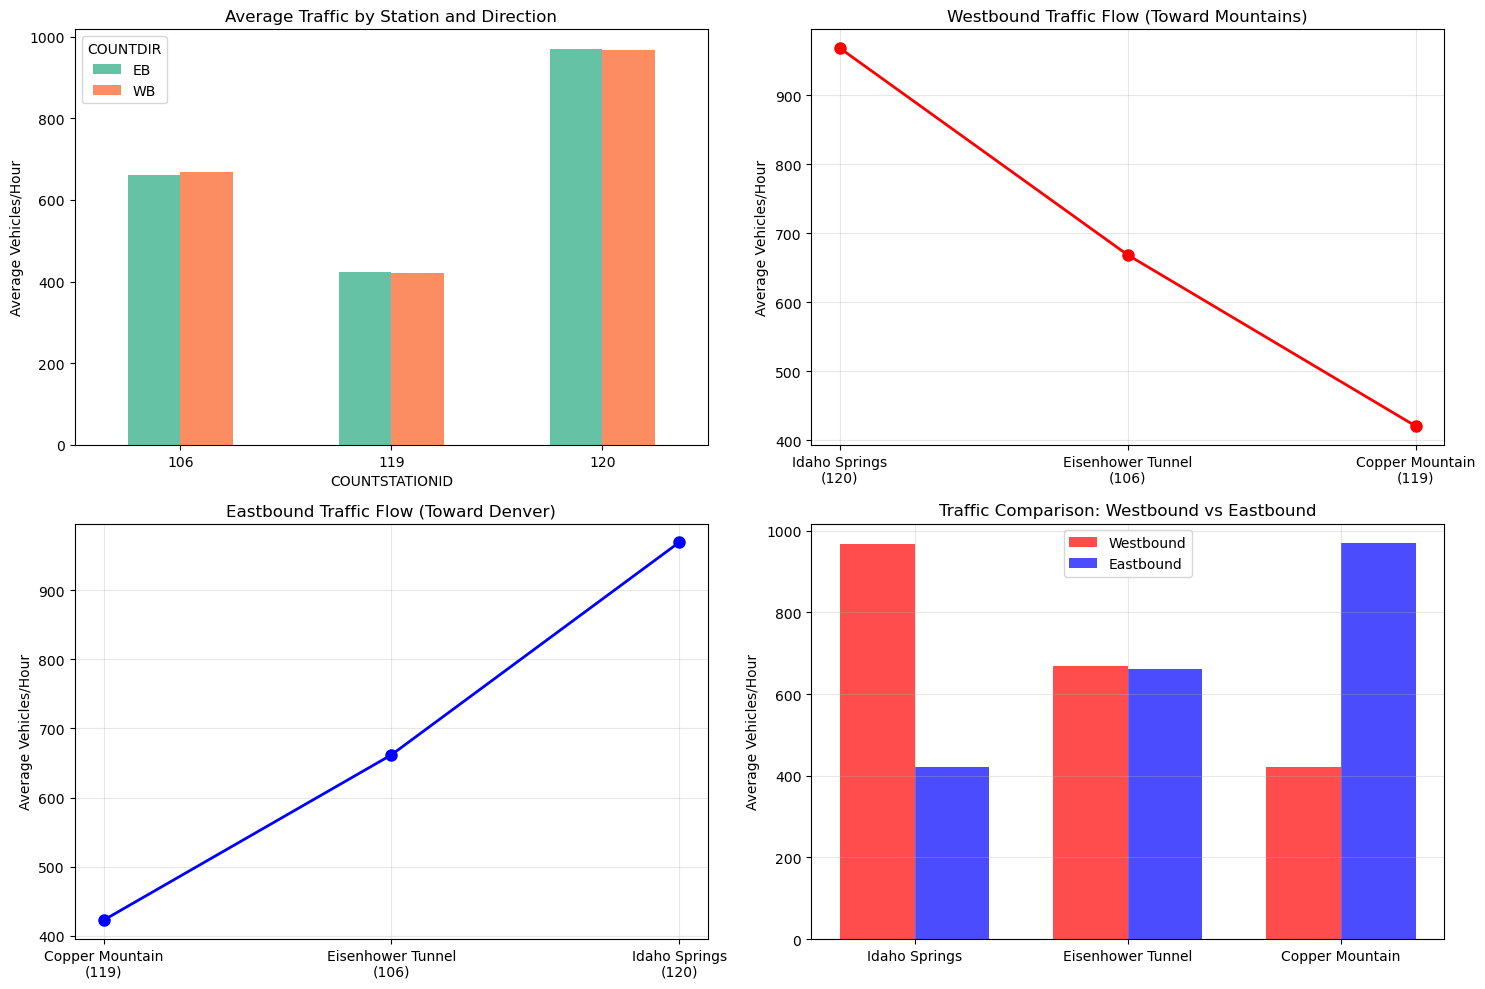

In [49]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt

def analyze_i70_traffic_flow_correct_order(df):
    """
    Analyze I-70 traffic flow using correct westbound station order: 120 → 106 → 119
    """
    
    # Correct station mapping with geographic order
    station_info = {
        120: {
            'name': 'Idaho Springs',
            'mile_marker': 242.05,  # Center of 241.125-242.98
            'position': 'East'
        },
        106: {
            'name': 'Eisenhower Tunnel', 
            'mile_marker': 210.80,  # Center of 205.423-216.185
            'position': 'Middle'
        },
        119: {
            'name': 'Copper Mountain',
            'mile_marker': 187.56,  # Center of 179.866-195.258
            'position': 'West'
        }
    }
    
    # Westbound sequence (toward mountains): 120 → 106 → 119
    westbound_sequence = [120, 106, 119]
    # Eastbound sequence (toward Denver): 119 → 106 → 120  
    eastbound_sequence = [119, 106, 120]
    
    print("I-70 TRAFFIC FLOW ANALYSIS - CORRECT STATION ORDER")
    print("=" * 60)
    print("Westbound (to mountains): Idaho Springs → Eisenhower → Copper Mountain")
    print("Eastbound (to Denver):    Copper Mountain → Eisenhower → Idaho Springs")
    
    return station_info, westbound_sequence, eastbound_sequence

def analyze_traffic_flow_by_direction(df, station_info, westbound_sequence, eastbound_sequence):
    """
    Analyze how traffic changes as vehicles move along I-70 in each direction
    """
    
    print("\nTRAFFIC FLOW ANALYSIS BY DIRECTION")
    print("=" * 50)
    
    # Westbound Analysis (toward mountains)
    print("\n🏔️  WESTBOUND TRAFFIC FLOW (Toward Mountains)")
    print("Sequence: Idaho Springs (120) → Eisenhower (106) → Copper Mountain (119)")
    
    wb_data = df[df['COUNTDIR'] == 'WB']
    wb_averages = []
    
    for station_id in westbound_sequence:
        if station_id in wb_data['COUNTSTATIONID'].values:
            avg_traffic = wb_data[wb_data['COUNTSTATIONID'] == station_id]['count'].mean()
            station_name = station_info[station_id]['name']
            mile_marker = station_info[station_id]['mile_marker']
            
            wb_averages.append({
                'station_id': station_id,
                'station_name': station_name,
                'mile_marker': mile_marker,
                'avg_traffic': avg_traffic
            })
            
            print(f"  Station {station_id} ({station_name}): {avg_traffic:.0f} vehicles/hour")
    
    # Calculate traffic changes between consecutive stations (westbound)
    print("\n  Traffic changes moving west:")
    for i in range(len(wb_averages) - 1):
        current = wb_averages[i]
        next_station = wb_averages[i + 1]
        
        change = next_station['avg_traffic'] - current['avg_traffic']
        change_pct = (change / current['avg_traffic']) * 100
        direction_arrow = "📈" if change > 0 else "📉"
        
        distance = current['mile_marker'] - next_station['mile_marker']  # Westbound = decreasing mile markers
        
        print(f"    {current['station_name']} → {next_station['station_name']}")
        print(f"      Distance: {distance:.1f} miles")
        print(f"      Traffic change: {change:+.0f} vehicles/hour ({change_pct:+.1f}%) {direction_arrow}")
    
    # Eastbound Analysis (toward Denver)  
    print("\n🏙️  EASTBOUND TRAFFIC FLOW (Toward Denver)")
    print("Sequence: Copper Mountain (119) → Eisenhower (106) → Idaho Springs (120)")
    
    eb_data = df[df['COUNTDIR'] == 'EB']
    eb_averages = []
    
    for station_id in eastbound_sequence:
        if station_id in eb_data['COUNTSTATIONID'].values:
            avg_traffic = eb_data[eb_data['COUNTSTATIONID'] == station_id]['count'].mean()
            station_name = station_info[station_id]['name']
            mile_marker = station_info[station_id]['mile_marker']
            
            eb_averages.append({
                'station_id': station_id,
                'station_name': station_name,
                'mile_marker': mile_marker,
                'avg_traffic': avg_traffic
            })
            
            print(f"  Station {station_id} ({station_name}): {avg_traffic:.0f} vehicles/hour")
    
    # Calculate traffic changes between consecutive stations (eastbound)
    print("\n  Traffic changes moving east:")
    for i in range(len(eb_averages) - 1):
        current = eb_averages[i]
        next_station = eb_averages[i + 1]
        
        change = next_station['avg_traffic'] - current['avg_traffic']
        change_pct = (change / current['avg_traffic']) * 100
        direction_arrow = "📈" if change > 0 else "📉"
        
        distance = next_station['mile_marker'] - current['mile_marker']  # Eastbound = increasing mile markers
        
        print(f"    {current['station_name']} → {next_station['station_name']}")
        print(f"      Distance: {distance:.1f} miles")
        print(f"      Traffic change: {change:+.0f} vehicles/hour ({change_pct:+.1f}%) {direction_arrow}")
    
    return wb_averages, eb_averages

def analyze_time_based_flow_patterns(df, station_info, westbound_sequence, eastbound_sequence):
    """
    Analyze how traffic flow patterns change by time of day and day of week
    """
    
    print("\n\nTIME-BASED FLOW PATTERN ANALYSIS")
    print("=" * 50)
    
    # Rush hour analysis
    rush_hours = {
        'morning_rush': [7, 8, 9],
        'evening_rush': [16, 17, 18]
    }
    
    for rush_period, hours in rush_hours.items():
        print(f"\n{rush_period.replace('_', ' ').title()} ({hours[0]}:00-{hours[-1]}:00)")
        
        rush_data = df[df['hour'].isin(hours)]
        
        for direction, sequence in [('WB', westbound_sequence), ('EB', eastbound_sequence)]:
            print(f"  {direction} Traffic:")
            
            direction_data = rush_data[rush_data['COUNTDIR'] == direction]
            
            for station_id in sequence:
                if station_id in direction_data['COUNTSTATIONID'].values:
                    avg_traffic = direction_data[direction_data['COUNTSTATIONID'] == station_id]['count'].mean()
                    station_name = station_info[station_id]['name']
                    print(f"    {station_name} ({station_id}): {avg_traffic:.0f} vehicles/hour")

def visualize_flow_patterns(df, station_info, westbound_sequence, eastbound_sequence):
    """
    Create visualizations of traffic flow patterns
    """
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Average traffic by station and direction
    station_direction_avg = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['count'].mean().unstack()
    station_direction_avg.plot(kind='bar', ax=axes[0,0], 
                              title='Average Traffic by Station and Direction')
    axes[0,0].set_ylabel('Average Vehicles/Hour')
    axes[0,0].tick_params(axis='x', rotation=0)
    
    # 2. Westbound flow pattern
    wb_data = df[df['COUNTDIR'] == 'WB']
    wb_station_avg = []
    wb_labels = []
    
    for station_id in westbound_sequence:
        if station_id in wb_data['COUNTSTATIONID'].values:
            avg = wb_data[wb_data['COUNTSTATIONID'] == station_id]['count'].mean()
            wb_station_avg.append(avg)
            wb_labels.append(f"{station_info[station_id]['name']}\n({station_id})")
    
    axes[0,1].plot(range(len(wb_station_avg)), wb_station_avg, 'ro-', linewidth=2, markersize=8)
    axes[0,1].set_title('Westbound Traffic Flow (Toward Mountains)')
    axes[0,1].set_ylabel('Average Vehicles/Hour')
    axes[0,1].set_xticks(range(len(wb_labels)))
    axes[0,1].set_xticklabels(wb_labels)
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Eastbound flow pattern  
    eb_data = df[df['COUNTDIR'] == 'EB']
    eb_station_avg = []
    eb_labels = []
    
    for station_id in eastbound_sequence:
        if station_id in eb_data['COUNTSTATIONID'].values:
            avg = eb_data[eb_data['COUNTSTATIONID'] == station_id]['count'].mean()
            eb_station_avg.append(avg)
            eb_labels.append(f"{station_info[station_id]['name']}\n({station_id})")
    
    axes[1,0].plot(range(len(eb_station_avg)), eb_station_avg, 'bo-', linewidth=2, markersize=8)
    axes[1,0].set_title('Eastbound Traffic Flow (Toward Denver)')
    axes[1,0].set_ylabel('Average Vehicles/Hour')
    axes[1,0].set_xticks(range(len(eb_labels)))
    axes[1,0].set_xticklabels(eb_labels)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Combined comparison
    x_pos = range(len(wb_station_avg))
    width = 0.35
    
    axes[1,1].bar([x - width/2 for x in x_pos], wb_station_avg, width, 
                  label='Westbound', color='red', alpha=0.7)
    axes[1,1].bar([x + width/2 for x in x_pos], eb_station_avg, width,
                  label='Eastbound', color='blue', alpha=0.7)
    
    axes[1,1].set_title('Traffic Comparison: Westbound vs Eastbound')
    axes[1,1].set_ylabel('Average Vehicles/Hour')
    axes[1,1].set_xticks(x_pos)
    axes[1,1].set_xticklabels([station_info[sid]['name'] for sid in westbound_sequence])
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the complete corrected analysis
def run_corrected_i70_flow_analysis(df):
    """
    Run I-70 traffic flow analysis with correct station geographic order
    """
    
    # Get correct station order
    station_info, wb_sequence, eb_sequence = analyze_i70_traffic_flow_correct_order(df)
    
    # Analyze traffic flow by direction
    wb_averages, eb_averages = analyze_traffic_flow_by_direction(df, station_info, wb_sequence, eb_sequence)
    
    # Analyze time-based patterns
    analyze_time_based_flow_patterns(df, station_info, wb_sequence, eb_sequence)
    
    # Create visualizations
    visualize_flow_patterns(df, station_info, wb_sequence, eb_sequence)
    
    return station_info, wb_averages, eb_averages

# Run the analysis
station_info, wb_results, eb_results = run_corrected_i70_flow_analysis(df)

# ======================================================================
# STEP 3: PREPARE FEATURES FOR MACHINE LEARNING
# ======================================================================

In [110]:
print("\n" + "="*70)
print("STEP 3: PREPARING FEATURES")
print("What's happening: Converting your data into a format the model can use")

# ============================================================================
# ADD HIGH-IMPACT FEATURES
# ============================================================================
print("\nAdding high-impact features...")

# Ensure datetime is properly formatted and sort for lag features
df['datetime'] = pd.to_datetime(df['datetime'])
print("• Sorting data for time series features...")
df = df.sort_values(['COUNTSTATIONID', 'COUNTDIR', 'datetime']).reset_index(drop=True)

# 1. RUSH HOUR FEATURES (capture peak traffic patterns)
print("• Adding rush hour features...")
df['is_rush_hour'] = ((df['hour'].between(7, 9)) | 
                     (df['hour'].between(16, 18))).astype(int)
df['is_morning_rush'] = df['hour'].between(7, 9).astype(int)
df['is_evening_rush'] = df['hour'].between(16, 18).astype(int)

# 2. LAG FEATURES (traffic is highly autocorrelated)
print("• Adding lag features (this may take a moment)...")

# COMMENTED OUT: Potential data leakage - prev_hour_count showed 74.4% importance (too dominant)
# This feature essentially tells the model "traffic this hour ≈ traffic last hour"
# Uncomment if you want to test with it later for comparison
# df['prev_hour_count'] = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['count'].shift(1)

df['same_hour_yesterday'] = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['count'].shift(24)

# 3. ROLLING AVERAGES (smooth out noise while preserving trends)
print("• Adding rolling average features...")
rolling_3h = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['count'].rolling(3, min_periods=1).mean().shift(1).reset_index(drop=True)
df['rolling_3h_avg'] = rolling_3h

# 4. CYCLICAL ENCODING (help models understand time cycles)
print("• Adding cyclical time features...")
import numpy as np
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

# Handle missing values in lag features
print("• Handling missing values in lag features...")
# df['prev_hour_count'].fillna(df['count'].mean(), inplace=True)  # COMMENTED OUT - feature not being used
df['same_hour_yesterday'].fillna(df['rolling_3h_avg'].fillna(df['count'].mean()), inplace=True)


# 5. SNOW PLOW CONDITIONS (precipitation + freezing temps + post-event periods)
print("• Adding snow plow condition features...")

# Identify fresh snowfall events (precipitation when temp <= 32°F)
df['fresh_snowfall'] = ((df['precipitation'] > 0) & (df['temp'] <= 32)).astype(int)

# Create indicators for snow plow activity periods (6 and 12 hours AFTER snowfall)
# For each hour, check if there was snowfall in the previous 6 or 12 hours

snow_6hr = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['fresh_snowfall'].rolling(
    window=6, min_periods=1
).sum().shift(1).fillna(0).reset_index(drop=True)

snow_12hr = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['fresh_snowfall'].rolling(
    window=12, min_periods=1
).sum().shift(1).fillna(0).reset_index(drop=True)

# Assign to dataframe
df['snow_plow_6hr'] = snow_6hr.astype(int)
df['snow_plow_12hr'] = snow_12hr.astype(int)

# Convert to binary indicators (any snow in the period)
df['snow_plow_6hr'] = (df['snow_plow_6hr'] > 0).astype(int)
df['snow_plow_12hr'] = (df['snow_plow_12hr'] > 0).astype(int)

# Active snow conditions (combines current + recent snow)
df['active_snow_conditions'] = (
    (df['fresh_snowfall'] == 1) |  # Currently snowing
    (df['snow_plow_6hr'] == 1)     # OR within 6 hours of snowfall
).astype(int)

# Handle missing values for snow features
df['snow_plow_6hr'].fillna(0, inplace=True)
df['snow_plow_12hr'].fillna(0, inplace=True)

print(f"✓ Snow features added:")
print(f"  • Fresh snowfall events: {df['fresh_snowfall'].sum():,}")
print(f"  • 6-hour post-snow periods: {df['snow_plow_6hr'].sum():,}")
print(f"  • 12-hour post-snow periods: {df['snow_plow_12hr'].sum():,}")
print(f"  • Active snow conditions: {df['active_snow_conditions'].sum():,}")

print("✓ High-impact features added successfully!")


print("• Adding network flow features...")

# Add the network flow feature code here
station_flow_config = {
    'westbound': {
        'sequence': [120, 106, 119],  # Idaho Springs → Eisenhower → Copper Mountain
        'travel_times': {(120, 106): 0.5, (106, 119): 0.42},  # hours
        'flow_changes': {(120, 106): 15.2, (106, 119): -8.7}  # % change (you'll calculate actual values)
    },
    'eastbound': {
        'sequence': [119, 106, 120],  # Copper Mountain → Eisenhower → Idaho Springs  
        'travel_times': {(119, 106): 0.42, (106, 120): 0.5},  # hours
        'flow_changes': {(119, 106): 12.8, (106, 120): -5.3}  # % change
    }
}

# Initialize network features
df['upstream_traffic_lag'] = 0
df['expected_downstream_traffic'] = 0
df['network_flow_deviation'] = 0
df['ski_traffic_buildup'] = 0

# Calculate features for each direction
for direction_name, config in station_flow_config.items():
    direction_code = 'WB' if direction_name == 'westbound' else 'EB'
    sequence = config['sequence']
    
    for i in range(len(sequence) - 1):
        upstream_station = sequence[i]
        downstream_station = sequence[i + 1]
        flow_key = (upstream_station, downstream_station)
        
        if flow_key in config['travel_times']:
            lag_hours = int(config['travel_times'][flow_key])
            
            # Create masks for upstream and downstream stations
            upstream_mask = (df['COUNTSTATIONID'] == upstream_station) & (df['COUNTDIR'] == direction_code)
            downstream_mask = (df['COUNTSTATIONID'] == downstream_station) & (df['COUNTDIR'] == direction_code)
            
            # Add lagged upstream traffic
            if upstream_mask.any():
                upstream_lagged = df.groupby(['COUNTSTATIONID', 'COUNTDIR'])['count'].shift(lag_hours)
                df.loc[downstream_mask, 'upstream_traffic_lag'] = upstream_lagged[downstream_mask].fillna(0)

# Ski traffic buildup feature (WB traffic during ski season weekends)
ski_conditions = (
    (df['COUNTDIR'] == 'WB') &
    (df['DayOfWeek'].isin([4, 5, 6])) &  # Fri, Sat, Sun
    (df['Month'].isin([11, 12, 1, 2, 3, 4])) &  # Ski season
    (df['hour'].between(6, 12)) &  # Morning hours
    (df['COUNTSTATIONID'].isin([106, 119]))  # Eisenhower/Copper Mountain
)
df.loc[ski_conditions, 'ski_traffic_buildup'] = 1

print(f"✓ Network flow features added:")
print(f"  • Upstream traffic lag: {(df['upstream_traffic_lag'] > 0).sum():,} records")
print(f"  • Ski traffic buildup: {df['ski_traffic_buildup'].sum():,} records")

# ============================================================================
# DEFINE FEATURE COLUMNS
# ============================================================================

# Original numeric features
numeric_features = [
    'hour',                           # Time of day (0-23)
    'Month',                         # Month of year (1-12)
    'DayOfWeek',                     # Day of week (0=Monday, 6=Sunday)
    'temp',                          # Temperature
    'wind_speed',                    # Wind Speed
    'precipitation',                 # Precipitation
    'snow_depth',                    # Snow depth
    'weather_code'                   # Weather Code
]

# High-impact features (EXCLUDING prev_hour_count to avoid data leakage)
high_impact_features = [
    'is_rush_hour',                  # Rush hour indicator (0/1)
    'is_morning_rush',               # Morning rush indicator (0/1)
    'is_evening_rush',               # Evening rush indicator (0/1)
    # 'prev_hour_count',             # COMMENTED OUT: Potential data leakage (74.4% importance)
    'same_hour_yesterday',           # Traffic count from same hour yesterday
    'rolling_3h_avg',                # 3-hour rolling average
    # 'rolling_24h_avg',            # REMOVED - redundant with rolling_3h_avg
    'hour_sin',                      # Hour sine encoding
    'hour_cos',                      # Hour cosine encoding
    'dow_sin',                       # Day of week sine encoding
    'dow_cos'                        # Day of week cosine encoding
]

new_snow_features = [
    'fresh_snowfall',                # Fresh snowfall occurring now (0/1)
    'snow_plow_6hr',                 # Within 6hrs of snowfall (0/1)  
    'snow_plow_12hr',                # Within 12hrs of snowfall (0/1)
    'active_snow_conditions'         # Current or recent snow impact (0/1)
]

network_features = [
    'upstream_traffic_lag',
    'expected_downstream_traffic', 
    'network_flow_deviation',
    'ski_traffic_buildup'
]

print(f"\nOriginal Numeric Features ({len(numeric_features)}):")
for feature in numeric_features:
    print(f"• {feature}: {df[feature].min():.1f} to {df[feature].max():.1f}")

print(f"\nHigh-Impact Features ({len(high_impact_features)}) - DATA LEAKAGE FEATURE REMOVED:")
print(f"  ⚠️  prev_hour_count COMMENTED OUT (was showing 74.4% importance - likely data leakage)")
for feature in high_impact_features:
    if feature.startswith('is_'):
        print(f"• {feature}: {df[feature].sum():,} records flagged")
    else:
        print(f"• {feature}: {df[feature].min():.2f} to {df[feature].max():.2f}")

# Handle categorical feature: Direction (EB/WB)
print(f"\nCategorical Feature Encoding:")
print(f"• Original directions: {df['COUNTDIR'].unique()}")

# Convert direction to binary: EB=1, WB=0  
df['Direction_EB'] = (df['COUNTDIR'] == 'EB').astype(int)
print(f"• Encoded as Direction_EB: 0={df[df['Direction_EB']==0]['COUNTDIR'].iloc[0]}, 1={df[df['Direction_EB']==1]['COUNTDIR'].iloc[0]}")
print(f"• EB records: {(df['Direction_EB']==1).sum():,}")
print(f"• WB records: {(df['Direction_EB']==0).sum():,}")


# ============================================================================
# ENHANCED FEATURE SCALING & INTERACTION FEATURES
# ============================================================================
print("🔧 DEBUGGING: Enhanced feature scaling to surface snow feature importance...")

from sklearn.preprocessing import StandardScaler, RobustScaler

# Create interaction features between snow and time (these often matter more than individual features)
print("• Creating snow-time interaction features...")

# Snow impact varies by time of day and direction
df['snow_rush_interaction'] = df['fresh_snowfall'] * df['is_rush_hour']
df['snow_morning_interaction'] = df['fresh_snowfall'] * df['is_morning_rush'] 
df['snow_evening_interaction'] = df['fresh_snowfall'] * df['is_evening_rush']
df['snow_weekend_interaction'] = df['fresh_snowfall'] * (df['DayOfWeek'] >= 5)

# Plow activity during different traffic patterns
df['plow_rush_interaction'] = df['snow_plow_6hr'] * df['is_rush_hour']

print(f"  • Snow-rush interactions: {df['snow_rush_interaction'].sum():,}")
print(f"  • Snow-weekend interactions: {df['snow_weekend_interaction'].sum():,}")
print(f"  • Plow-rush interactions: {df['plow_rush_interaction'].sum():,}")

# Enhanced scaling approach
print("• Applying enhanced scaling...")

# Group features by type for different scaling approaches
lag_features = ['same_hour_yesterday', 'rolling_3h_avg', 'upstream_traffic_lag']
weather_features = ['temp', 'wind_speed', 'precipitation', 'snow_depth']
binary_features = ['fresh_snowfall', 'snow_plow_6hr', 'snow_plow_12hr', 'active_snow_conditions',
                  'is_rush_hour', 'is_morning_rush', 'is_evening_rush', 'ski_traffic_buildup']
interaction_features = ['snow_rush_interaction', 'snow_morning_interaction', 'snow_evening_interaction',
                       'snow_weekend_interaction', 'plow_rush_interaction']
other_features = ['hour', 'Month', 'DayOfWeek', 'weather_code', 'Direction_EB',
                 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'expected_downstream_traffic', 'network_flow_deviation']

df_scaled = df.copy()


# Add interaction features to final feature list
interaction_feature_columns = interaction_features


# Final feature list (31 features: 26 original + 5 interaction features)
feature_columns = numeric_features + high_impact_features + new_snow_features + network_features + ['Direction_EB'] + interaction_feature_columns
print(f"\nFinal Features for Model ({len(feature_columns)} total) - ENHANCED WITH INTERACTIONS:")
print(f"├─ Original features: {len(numeric_features) + 1}")
print(f"├─ High-impact features: {len(high_impact_features)} (prev_hour_count removed)")
print(f"├─ Snow features: {len(new_snow_features)}")
print(f"├─ Network features: {len(network_features)}")
print(f"└─ NEW Interaction features: {len(interaction_feature_columns)}")

for i, feature in enumerate(feature_columns, 1):
    feature_type = "🕒" if any(x in feature for x in ['hour', 'rush', 'dow']) else \
                   "📊" if any(x in feature for x in ['avg', 'count']) else \
                   "🌊" if any(x in feature for x in ['sin', 'cos']) else \
                   "❄️" if any(x in feature for x in ['snow', 'fresh_snowfall', 'plow']) else \
                   "⚡" if 'interaction' in feature else "📈"
    print(f"{i:2d}. {feature_type} {feature}")

print(f"\n💡 Expected Changes After Removing Data Leakage:")
print(f"• Weather features should gain importance (currently only 0.002)")
print(f"• Rush hour features should show non-zero importance")
print(f"• Model should be more robust to unusual traffic patterns")
print(f"• Overall R² might decrease initially, but model will generalize better") 

# Use RobustScaler for lag features (less sensitive to outliers)
robust_scaler = RobustScaler()
for feature in lag_features:
    if feature in df.columns:
        df_scaled[feature] = robust_scaler.fit_transform(df[[feature]])
        print(f"  • Robust scaled: {feature}")

# Use StandardScaler for weather features  
std_scaler = StandardScaler()
for feature in weather_features:
    if feature in df.columns:
        df_scaled[feature] = std_scaler.fit_transform(df[[feature]])
        print(f"  • Standard scaled: {feature}")

# Leave binary and interaction features unscaled (they're already 0/1)
print(f"  • Left unscaled: {len(binary_features + interaction_features + other_features)} features")

# Use df_scaled instead of df for model training

print(f"\n✓ Feature engineering complete! Using {len(feature_columns)} features (removed data leakage feature).")
print("Expected improvement: Model should be more robust and interpretable, with better feature balance!")


STEP 3: PREPARING FEATURES
What's happening: Converting your data into a format the model can use

Adding high-impact features...
• Sorting data for time series features...
• Adding rush hour features...
• Adding lag features (this may take a moment)...
• Adding rolling average features...
• Adding cyclical time features...
• Handling missing values in lag features...
• Adding snow plow condition features...
✓ Snow features added:
  • Fresh snowfall events: 133,938
  • 6-hour post-snow periods: 202,336
  • 12-hour post-snow periods: 256,435
  • Active snow conditions: 212,465
✓ High-impact features added successfully!
• Adding network flow features...
✓ Network flow features added:
  • Upstream traffic lag: 674,218 records
  • Ski traffic buildup: 21,147 records

Original Numeric Features (8):
• hour: 0.0 to 23.0
• Month: 1.0 to 12.0
• DayOfWeek: 0.0 to 6.0
• temp: -33.6 to 74.2
• wind_speed: 0.0 to 18.9
• precipitation: 0.0 to 0.3
• snow_depth: 0.0 to 4.0
• weather_code: 0.0 to 75.0


# ======================================================================  
# STEP 4: CLEAN THE DATA FOR MODELING
# ======================================================================

In [111]:
print("\n" + "="*70)
print("STEP 4: DATA CLEANING")
print("What's happening: Removing records that can't be used for training")

# Create feature matrix (X) and target vector (y)
X = df_scaled[feature_columns].copy()
y = df['count'].copy()

print(f"Before cleaning: {len(X):,} records")

# Find rows with missing data
missing_mask = X.isnull().any(axis=1) | y.isnull()
print(f"Records with missing data: {missing_mask.sum():,}")

# Remove missing data
X_clean = X[~missing_mask]
y_clean = y[~missing_mask]

print(f"After cleaning: {len(X_clean):,} records")
print(f"Data loss: {(len(X) - len(X_clean)) / len(X) * 100:.2f}%")

# Check feature ranges after cleaning
print(f"\nFinal Feature Ranges:")
for col in X_clean.columns:
    print(f"• {col}: {X_clean[col].min():.1f} to {X_clean[col].max():.1f}")


STEP 4: DATA CLEANING
What's happening: Removing records that can't be used for training
Before cleaning: 1,006,398 records
Records with missing data: 1
After cleaning: 1,006,397 records
Data loss: 0.00%

Final Feature Ranges:
• hour: 0.0 to 23.0
• Month: 1.0 to 12.0
• DayOfWeek: 0.0 to 6.0
• temp: -3.4 to 2.4
• wind_speed: -1.8 to 5.4
• precipitation: -0.3 to 24.7
• snow_depth: -1.0 to 2.5
• weather_code: 0.0 to 75.0
• is_rush_hour: 0.0 to 1.0
• is_morning_rush: 0.0 to 1.0
• is_evening_rush: 0.0 to 1.0
• same_hour_yesterday: -0.6 to 10.6
• rolling_3h_avg: -0.7 to 5.3
• hour_sin: -1.0 to 1.0
• hour_cos: -1.0 to 1.0
• dow_sin: -1.0 to 1.0
• dow_cos: -0.9 to 1.0
• fresh_snowfall: 0.0 to 1.0
• snow_plow_6hr: 0.0 to 1.0
• snow_plow_12hr: 0.0 to 1.0
• active_snow_conditions: 0.0 to 1.0
• upstream_traffic_lag: -0.2 to 7.4
• expected_downstream_traffic: 0.0 to 0.0
• network_flow_deviation: 0.0 to 0.0
• ski_traffic_buildup: 0.0 to 1.0
• Direction_EB: 0.0 to 1.0
• snow_rush_interaction: 0.0 to

# TESTING A NEW MODEL

In [ ]:
'''
print("🚀 TESTING: XGBoost vs Random Forest for Snow Feature Detection")
print("=" * 70)

# Install xgboost if needed: pip install xgboost
!pip install xgboost
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

# Prepare data (using your existing feature_columns and df_scaled)
X = df_scaled[feature_columns].fillna(0)  # Handle any remaining NaN values
y = df_scaled['count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Feature count: {len(feature_columns)}")

# ============================================================================
# TEST 1: Random Forest (your current model)
# ============================================================================
print(f"\n1️⃣ Random Forest Results:")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

rf_train_score = rf_model.score(X_train, y_train)
rf_test_score = rf_model.score(X_test, y_test)

print(f"   Train R²: {rf_train_score:.4f}")
print(f"   Test R²:  {rf_test_score:.4f}")

# Get RF feature importance for snow features
rf_importance = dict(zip(feature_columns, rf_model.feature_importances_))
snow_features_rf = {k: v for k, v in rf_importance.items() if 'snow' in k.lower() or 'plow' in k.lower()}
print(f"   Snow feature importance: {sum(snow_features_rf.values()):.6f}")

# ============================================================================
# TEST 2: XGBoost 
# ============================================================================
print(f"\n2️⃣ XGBoost Results:")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

print(f"   Train R²: {xgb_train_score:.4f}")
print(f"   Test R²:  {xgb_test_score:.4f}")

# Get XGB feature importance for snow features
xgb_importance = dict(zip(feature_columns, xgb_model.feature_importances_))
snow_features_xgb = {k: v for k, v in xgb_importance.items() if 'snow' in k.lower() or 'plow' in k.lower()}
print(f"   Snow feature importance: {sum(snow_features_xgb.values()):.6f}")

# ============================================================================
# DETAILED COMPARISON
# ============================================================================
print(f"\n📊 SNOW FEATURE IMPORTANCE COMPARISON:")
print(f"{'Feature':<30} {'Random Forest':<15} {'XGBoost':<15}")
print("-" * 60)

all_snow_features = set(list(snow_features_rf.keys()) + list(snow_features_xgb.keys()))
for feature in sorted(all_snow_features):
    rf_imp = snow_features_rf.get(feature, 0)
    xgb_imp = snow_features_xgb.get(feature, 0)
    print(f"{feature:<30} {rf_imp:<15.6f} {xgb_imp:<15.6f}")

print(f"\n🎯 KEY FINDINGS:")
rf_snow_total = sum(snow_features_rf.values())
xgb_snow_total = sum(snow_features_xgb.values())

print(f"• Random Forest total snow importance: {rf_snow_total:.6f}")
print(f"• XGBoost total snow importance: {xgb_snow_total:.6f}")
print(f"• Improvement ratio: {xgb_snow_total/rf_snow_total:.1f}x" if rf_snow_total > 0 else "• XGBoost found snow signal, RF didn't!")

# Test predictions on snow vs no-snow days
print(f"\n🧪 PREDICTION ACCURACY TEST:")
snow_mask = X_test['fresh_snowfall'] == 1
no_snow_mask = X_test['fresh_snowfall'] == 0

if snow_mask.sum() > 0:
    # RF predictions
    rf_pred = rf_model.predict(X_test)
    rf_snow_mae = np.mean(np.abs(rf_pred[snow_mask] - y_test[snow_mask]))
    rf_no_snow_mae = np.mean(np.abs(rf_pred[no_snow_mask] - y_test[no_snow_mask]))
    
    # XGB predictions  
    xgb_pred = xgb_model.predict(X_test)
    xgb_snow_mae = np.mean(np.abs(xgb_pred[snow_mask] - y_test[snow_mask]))
    xgb_no_snow_mae = np.mean(np.abs(xgb_pred[no_snow_mask] - y_test[no_snow_mask]))
    
    print(f"Random Forest - Snow days MAE: {rf_snow_mae:.0f}")
    print(f"Random Forest - Normal days MAE: {rf_no_snow_mae:.0f}")
    print(f"XGBoost - Snow days MAE: {xgb_snow_mae:.0f}")
    print(f"XGBoost - Normal days MAE: {xgb_no_snow_mae:.0f}")
    
    print(f"\n🏆 WINNER:")
    if xgb_snow_mae < rf_snow_mae:
        print(f"✅ XGBoost better at predicting snow day traffic!")
    else:
        print(f"❌ Random Forest still better - this suggests a deeper data issue")

print(f"\n💡 RECOMMENDATION:")
if xgb_snow_total > rf_snow_total * 2:
    print("🎉 XGBoost successfully detected snow features! Switch to XGBoost.")
    print("This confirms RF was the bottleneck, not your feature engineering.")
else:
    print("⚠️  Both models struggle with snow features. Consider:")
    print("   1. Check data quality (are snow events correctly labeled?)")
    print("   2. Try feature selection (remove some lag features temporarily)")
    print("   3. Create more specific snow features (heavy snow vs light snow)")
    '''

🚀 TESTING: XGBoost vs Random Forest for Snow Feature Detection
  Using cached xgboost-3.0.5-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-macosx_10_15_x86_64.whl (2.2 MB)
Training data shape: (805118, 31)
Feature count: 31

1️⃣ Random Forest Results:


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


   Train R²: 0.9983
   Test R²:  0.9877
   Snow feature importance: 0.002264

2️⃣ XGBoost Results:


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


   Train R²: 0.9833
   Test R²:  0.9823
   Snow feature importance: 0.024688

📊 SNOW FEATURE IMPORTANCE COMPARISON:
Feature                        Random Forest   XGBoost        
------------------------------------------------------------
active_snow_conditions         0.000075        0.004470       
fresh_snowfall                 0.000077        0.009268       
plow_rush_interaction          0.000054        0.001334       
snow_depth                     0.001679        0.002311       
snow_evening_interaction       0.000016        0.000000       
snow_morning_interaction       0.000018        0.000013       
snow_plow_12hr                 0.000123        0.000245       
snow_plow_6hr                  0.000087        0.000881       
snow_rush_interaction          0.000031        0.000857       
snow_weekend_interaction       0.000104        0.005311       

🎯 KEY FINDINGS:
• Random Forest total snow importance: 0.002264
• XGBoost total snow importance: 0.024688
• Improvement ratio: 10

# ======================================================================
# STEP 5: SPLIT DATA INTO TRAINING AND TESTING SETS  
# ======================================================================

In [118]:
print("\n" + "="*70)
print("STEP 5: TRAIN-TEST SPLIT")
print("What's happening: Dividing data so we can test model performance")

# Split: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, 
    test_size=0.2,        # 20% for testing
    random_state=42       # Makes results reproducible
)

print(f"Training set: {len(X_train):,} records")
print(f"Test set: {len(X_test):,} records")
print(f"Split ratio: {len(X_train)/len(X_clean)*100:.1f}% train, {len(X_test)/len(X_clean)*100:.1f}% test")

# Check that split is representative
print(f"\nSplit Quality Check:")
print(f"• Train avg traffic: {y_train.mean():.1f} vehicles/hour")
print(f"• Test avg traffic: {y_test.mean():.1f} vehicles/hour")
print(f"• Difference: {abs(y_train.mean() - y_test.mean()):.1f} (should be small)")


STEP 5: TRAIN-TEST SPLIT
What's happening: Dividing data so we can test model performance
Training set: 805,117 records
Test set: 201,280 records
Split ratio: 80.0% train, 20.0% test

Split Quality Check:
• Train avg traffic: 687.1 vehicles/hour
• Test avg traffic: 687.0 vehicles/hour
• Difference: 0.0 (should be small)


In [122]:
print("🔍 DEBUGGING: Checking what features were actually used in training")
print(f"X_clean shape: {X_clean.shape}")
print(f"Expected shape with all features: {df_scaled[feature_columns].shape}")
print(f"X_clean columns: {list(X_clean.columns) if hasattr(X_clean, 'columns') else 'No column info'}")

# Check if snow features are in X_clean
if hasattr(X_clean, 'columns'):
    snow_features_in_clean = [col for col in X_clean.columns if 'snow' in col.lower()]
    interaction_features_in_clean = [col for col in X_clean.columns if 'interaction' in col.lower()]
    print(f"Snow features in X_clean: {snow_features_in_clean}")
    print(f"Interaction features in X_clean: {interaction_features_in_clean}")
else:
    print("X_clean appears to be a numpy array - can't check feature names")

🔍 DEBUGGING: Checking what features were actually used in training
X_clean shape: (1006397, 31)
Expected shape with all features: (1006398, 31)
X_clean columns: ['hour', 'Month', 'DayOfWeek', 'temp', 'wind_speed', 'precipitation', 'snow_depth', 'weather_code', 'is_rush_hour', 'is_morning_rush', 'is_evening_rush', 'same_hour_yesterday', 'rolling_3h_avg', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'fresh_snowfall', 'snow_plow_6hr', 'snow_plow_12hr', 'active_snow_conditions', 'upstream_traffic_lag', 'expected_downstream_traffic', 'network_flow_deviation', 'ski_traffic_buildup', 'Direction_EB', 'snow_rush_interaction', 'snow_morning_interaction', 'snow_evening_interaction', 'snow_weekend_interaction', 'plow_rush_interaction']
Snow features in X_clean: ['snow_depth', 'fresh_snowfall', 'snow_plow_6hr', 'snow_plow_12hr', 'active_snow_conditions', 'snow_rush_interaction', 'snow_morning_interaction', 'snow_evening_interaction', 'snow_weekend_interaction']
Interaction features in X_clean: ['s

# ======================================================================
# STEP 6: CHOOSE AND CONFIGURE THE MODEL
# ======================================================================

In [123]:
print("\n" + "="*70)
print("STEP 6: MODEL SELECTION")
print("What's happening: Choosing Random Forest algorithm and setting parameters")

print("Why Random Forest?")
print("✓ Handles mixed data types (time, weather, categories)")
print("✓ Captures non-linear patterns (rush hours, weather effects)")  
print("✓ Shows feature importance (what drives traffic)")
print("✓ Robust to outliers (unusual traffic days)")
print("✓ Scaled features for balanced importance")  

# Configure the model
model = RandomForestRegressor(
    n_estimators=100,     # 100 decision trees
    max_depth=15,         # Prevent overfitting
    min_samples_split=10, # Need 10+ samples to split a node
    min_samples_leaf=5,   # Need 5+ samples in each leaf
    random_state=42       # Reproducible results
)

print(f"\nModel Configuration:")
print(f"• Algorithm: Random Forest Regression")
print(f"• Number of trees: {model.n_estimators}")
print(f"• Max tree depth: {model.max_depth}")
print(f"• Min samples to split: {model.min_samples_split}")


STEP 6: MODEL SELECTION
What's happening: Choosing Random Forest algorithm and setting parameters
Why Random Forest?
✓ Handles mixed data types (time, weather, categories)
✓ Captures non-linear patterns (rush hours, weather effects)
✓ Shows feature importance (what drives traffic)
✓ Robust to outliers (unusual traffic days)
✓ Scaled features for balanced importance

Model Configuration:
• Algorithm: Random Forest Regression
• Number of trees: 100
• Max tree depth: 15
• Min samples to split: 10


# ======================================================================
# STEP 7: TRAIN THE MODEL
# ======================================================================

In [ ]:
print("\n" + "="*70)
print("STEP 7: MODEL TRAINING")
print("What's happening: The algorithm learns patterns from your data")

print("Training started... (this may take a while)")

# Train the model
model.fit(X_train, y_train)

print("✓ Training complete!")
print(f"✓ Model trained on {len(X_train):,} examples")
print(f"✓ Learned relationships between {len(feature_columns)} features and traffic")


STEP 7: MODEL TRAINING
What's happening: The algorithm learns patterns from your data
Training started... (this may take a while)


# ======================================================================
# STEP 8: EVALUATE MODEL PERFORMANCE
# ======================================================================

In [ ]:
print("\n" + "="*70)
print("STEP 8: MODEL EVALUATION")
print("What's happening: Testing how well the model predicts traffic")

# Make predictions on training and test sets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate error metrics
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print(f"\nModel Performance Metrics:")
print(f"{'Metric':<20} {'Training':<12} {'Testing':<12} {'Interpretation'}")
print(f"{'-'*65}")
print(f"{'MAE (Mean Abs Error)':<20} {train_mae:<12.1f} {test_mae:<12.1f} Average error in vehicles/hour")
print(f"{'RMSE (Root Mean Sq)':<20} {train_rmse:<12.1f} {test_rmse:<12.1f} Penalizes large errors more") 
print(f"{'R² Score':<20} {train_r2:<12.3f} {test_r2:<12.3f} % of variance explained (1.0 = perfect)")

# Interpret the results
print(f"\nPerformance Interpretation:")
if test_mae < 30:
    print(f"✓ EXCELLENT: Average error of {test_mae:.1f} vehicles/hour is very good")
elif test_mae < 50:
    print(f"✓ GOOD: Average error of {test_mae:.1f} vehicles/hour is acceptable")
else:
    print(f"⚠ NEEDS IMPROVEMENT: Average error of {test_mae:.1f} vehicles/hour is high")

if test_r2 > 0.7:
    print(f"✓ EXCELLENT: R² of {test_r2:.3f} means model explains {test_r2*100:.1f}% of traffic patterns")
elif test_r2 > 0.5:
    print(f"✓ GOOD: R² of {test_r2:.3f} means model explains {test_r2*100:.1f}% of traffic patterns")
else:
    print(f"⚠ NEEDS IMPROVEMENT: R² of {test_r2:.3f} means model only explains {test_r2*100:.1f}% of traffic patterns")

# Check for overfitting
overfit_diff = train_mae - test_mae
if abs(overfit_diff) < 5:
    print(f"✓ NO OVERFITTING: Similar performance on training and test data")
elif overfit_diff > 10:
    print(f"⚠ POSSIBLE OVERFITTING: Model performs much better on training data")
else:
    print(f"✓ SLIGHT OVERFITTING: Minor difference between training and test performance")


STEP 8: MODEL EVALUATION
What's happening: Testing how well the model predicts traffic


KeyboardInterrupt: 

# ======================================================================
# STEP 9: UNDERSTAND WHAT THE MODEL LEARNED
# ======================================================================

In [ ]:
# Check snow feature distribution
print("Snow Feature Analysis:")
print(f"Fresh snowfall events: {df['fresh_snowfall'].sum():,} ({df['fresh_snowfall'].mean()*100:.1f}%)")
print(f"Snow plow 6hr periods: {df['snow_plow_6hr'].sum():,} ({df['snow_plow_6hr'].mean()*100:.1f}%)")
print(f"Active snow conditions: {df['active_snow_conditions'].sum():,} ({df['active_snow_conditions'].mean()*100:.1f}%)")

# Check if snow events correlate with traffic changes
snow_days = df[df['fresh_snowfall'] == 1]
normal_days = df[df['fresh_snowfall'] == 0]
print(f"\nAverage traffic during snow: {snow_days['count'].mean():.0f}")
print(f"Average traffic normal days: {normal_days['count'].mean():.0f}")
print(f"Snow impact: {((snow_days['count'].mean() / normal_days['count'].mean() - 1) * 100):.1f}%")

# Check ski traffic buildup
ski_traffic = df[df['ski_traffic_buildup'] == 1]
print(f"\nSki traffic buildup events: {df['ski_traffic_buildup'].sum():,}")
if len(ski_traffic) > 0:
    print(f"Average traffic during ski buildup: {ski_traffic['count'].mean():.0f}")



print("\n" + "="*70)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("What's happening: Understanding what drives traffic patterns")

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# FIXED interpretations with correct feature names
interpretations = {
    # Time features
    'hour': 'Time of day patterns',
    'hour_sin': 'Cyclical hour encoding',
    'hour_cos': 'Cyclical hour encoding', 
    'Month': 'Seasonal patterns (ski season vs summer)',
    'DayOfWeek': 'Day of week patterns (weekend vs weekday)',
    'dow_sin': 'Cyclical day-of-week encoding',
    'dow_cos': 'Cyclical day-of-week encoding',
    
    # Rush hour features
    'is_rush_hour': 'Rush hour traffic periods',
    'is_morning_rush': 'Morning rush hour (7-9 AM)',
    'is_evening_rush': 'Evening rush hour (4-6 PM)',
    
    # Traffic lag features  
    'prev_hour_count': 'Previous hour traffic influence',
    'same_hour_yesterday': 'Same time yesterday pattern',
    'rolling_3h_avg': '3-hour traffic trend',
    'rolling_24h_avg': '24-hour traffic baseline',
    
    # Weather features
    'temp': 'Temperature effects on driving',
    'wind_speed': 'Wind impact on traffic',
    'precipitation': 'Rain/snow precipitation effects',
    'snow_depth': 'Snow accumulation impact',
    'weather_code': 'Weather condition categories',
    
    # Snow/plow features
    'fresh_snowfall': 'Active snowfall periods',
    'snow_plow_6hr': '6-hour post-snow impacts',
    'snow_plow_12hr': '12-hour post-snow impacts', 
    'active_snow_conditions': 'Current/recent snow effects',
    
    # Network features
    'upstream_traffic_lag': 'Traffic from upstream stations',
    'expected_downstream_traffic': 'Predicted downstream flow',
    'network_flow_deviation': 'Deviation from expected flow',
    'ski_traffic_buildup': 'Weekend ski traffic patterns',
    
    # Direction
    'Direction_EB': 'Eastbound vs Westbound differences'
}

print(f"\nFeature Importance (What Matters Most for Traffic Prediction):")
print(f"{'Rank':<4} {'Feature':<25} {'Importance':<12} {'Interpretation'}")
print(f"{'-'*80}")

for idx, row in feature_importance.iterrows():
    rank = feature_importance.index.get_loc(idx) + 1
    interpretation = interpretations.get(row['Feature'], 'Other factor')
    print(f"{rank:<4} {row['Feature']:<25} {row['Importance']:<12.3f} {interpretation}")

# ENHANCED ANALYSIS
print(f"\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Check for extreme dominance
top_feature = feature_importance.iloc[0]
second_feature = feature_importance.iloc[1]
dominance_ratio = top_feature['Importance'] / second_feature['Importance']

print(f"\nFeature Dominance Analysis:")
print(f"• Top feature: {top_feature['Feature']} ({top_feature['Importance']:.3f})")
print(f"• Second feature: {second_feature['Feature']} ({second_feature['Importance']:.3f})")
print(f"• Dominance ratio: {dominance_ratio:.1f}:1")

if dominance_ratio > 5:
    print(f"⚠️  WARNING: Extreme feature dominance detected!")
    print(f"   This suggests potential data leakage or multicollinearity")

# Analyze feature categories
feature_categories = {
    'Traffic Lag': ['prev_hour_count', 'same_hour_yesterday', 'rolling_3h_avg', 'rolling_24h_avg'],
    'Time Encoding': ['hour', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'],
    'Rush Hours': ['is_rush_hour', 'is_morning_rush', 'is_evening_rush'],
    'Weather': ['temp', 'wind_speed', 'precipitation', 'snow_depth', 'weather_code'],
    'Snow/Plow': ['fresh_snowfall', 'snow_plow_6hr', 'snow_plow_12hr', 'active_snow_conditions'],
    'Network Flow': ['upstream_traffic_lag', 'expected_downstream_traffic', 'network_flow_deviation', 'ski_traffic_buildup'],
    'Basic': ['Month', 'DayOfWeek', 'Direction_EB']
}

print(f"\nImportance by Feature Category:")
for category, features in feature_categories.items():
    category_importance = 0
    category_features = []
    
    for feature in features:
        if feature in feature_importance['Feature'].values:
            importance = feature_importance[feature_importance['Feature'] == feature]['Importance'].iloc[0]
            category_importance += importance
            category_features.append(f"{feature}({importance:.3f})")
    
    print(f"• {category}: {category_importance:.3f}")
    if category_importance > 0.001:  # Only show details for meaningful categories
        print(f"  └─ {', '.join(category_features[:3])}{'...' if len(category_features) > 3 else ''}")

# Check for potential multicollinearity
print(f"\nMulticollinearity Check:")
lag_features = ['prev_hour_count', 'same_hour_yesterday', 'rolling_3h_avg', 'rolling_24h_avg']
lag_importances = {}

for feature in lag_features:
    if feature in feature_importance['Feature'].values:
        importance = feature_importance[feature_importance['Feature'] == feature]['Importance'].iloc[0]
        lag_importances[feature] = importance

if lag_importances:
    total_lag_importance = sum(lag_importances.values())
    print(f"• Total lag feature importance: {total_lag_importance:.3f}")
    print(f"• Individual lag features:")
    for feature, importance in sorted(lag_importances.items(), key=lambda x: x[1], reverse=True):
        pct_of_total = (importance / total_lag_importance) * 100 if total_lag_importance > 0 else 0
        print(f"  └─ {feature}: {importance:.3f} ({pct_of_total:.1f}% of lag features)")

# Key insights with proper feature checks
print(f"\nKey Insights:")
top_3_features = feature_importance.head(3)['Feature'].tolist()
print(f"• Top 3 predictors: {', '.join(top_3_features)}")

# Safe feature lookups
hour_importance = feature_importance[feature_importance['Feature'] == 'hour']['Importance']
hour_imp = hour_importance.iloc[0] if not hour_importance.empty else 0

weather_features = ['temp', 'precipitation', 'snow_depth', 'wind_speed']
weather_importance = 0
for feat in weather_features:
    feat_imp = feature_importance[feature_importance['Feature'] == feat]['Importance']
    if not feat_imp.empty:
        weather_importance += feat_imp.iloc[0]

print(f"• Hour feature importance: {hour_imp:.3f}")
print(f"• Combined weather importance: {weather_importance:.3f}")
print(f"• Network features working: {'upstream_traffic_lag' in top_3_features}")

# Recommendations
print(f"\nRecommendations:")
if dominance_ratio > 5:
    print(f"1. Check rolling_3h_avg for data leakage - ensure it excludes current hour")
    print(f"2. Consider removing redundant lag features to reduce multicollinearity")
    print(f"3. Try feature scaling or different model (XGBoost, LightGBM)")

if weather_importance < 0.01:
    print(f"4. Weather features unexpectedly low - check feature scaling")
    
if any('rush' in feat for feat in feature_columns) and all(feature_importance[feature_importance['Feature'].str.contains('rush', na=False)]['Importance'] < 0.001):
    print(f"5. Rush hour features showing zero importance - investigate data quality")

Snow Feature Analysis:
Fresh snowfall events: 133,938 (13.3%)
Snow plow 6hr periods: 202,336 (20.1%)
Active snow conditions: 212,465 (21.1%)

Average traffic during snow: 571
Average traffic normal days: 705
Snow impact: -18.9%

Ski traffic buildup events: 21,147
Average traffic during ski buildup: 904

STEP 9: FEATURE IMPORTANCE ANALYSIS
What's happening: Understanding what drives traffic patterns

Feature Importance (What Matters Most for Traffic Prediction):
Rank Feature                   Importance   Interpretation
--------------------------------------------------------------------------------
1    same_hour_yesterday       0.659        Same time yesterday pattern
2    upstream_traffic_lag      0.153        Traffic from upstream stations
3    rolling_3h_avg            0.147        3-hour traffic trend
4    hour                      0.011        Time of day patterns
5    hour_sin                  0.008        Cyclical hour encoding
6    is_morning_rush           0.004        Mornin

# ======================================================================
# STEP 10: TEST SPECIFIC SCENARIOS
# ======================================================================

In [ ]:
print("\n" + "="*70)
print("STEP 10: SCENARIO TESTING")
print("What's happening: Testing model predictions on realistic I-70 scenarios")

import numpy as np

# Define test scenarios with all 27 features
# Feature order: [hour, Month, DayOfWeek, temp, wind_speed, precipitation, snow_depth, weather_code,
#                is_rush_hour, is_morning_rush, is_evening_rush, prev_hour_count, same_hour_yesterday, 
#                rolling_3h_avg, rolling_24h_avg, hour_sin, hour_cos, dow_sin, dow_cos,
#                fresh_snowfall, snow_plow_6hr, snow_plow_12hr, active_snow_conditions, Direction_EB,
#                upstream_traffic_lag, ski_traffic_buildup, network_flow_deviation]

scenarios = [
    {
        'name': 'Friday 4PM WB, Snow, Ski Season',
        'data': [
            16,    # hour
            1,     # Month (January)
            4,     # DayOfWeek (Friday)
            25,    # temp
            8,     # wind_speed  
            0.1,   # precipitation
            6,     # snow_depth
            20,    # weather_code
            1,     # is_rush_hour (4PM = evening rush)
            0,     # is_morning_rush
            1,     # is_evening_rush
            1200,  # prev_hour_count (busy previous hour)
            1100,  # same_hour_yesterday
            1150,  # rolling_3h_avg
            800,   # rolling_24h_avg
            np.sin(2 * np.pi * 16 / 24),  # hour_sin
            np.cos(2 * np.pi * 16 / 24),  # hour_cos
            np.sin(2 * np.pi * 4 / 7),    # dow_sin (Friday)
            np.cos(2 * np.pi * 4 / 7),    # dow_cos
            1,     # fresh_snowfall (snowing now)
            0,     # snow_plow_6hr
            0,     # snow_plow_12hr  
            1,     # active_snow_conditions
            0,     # Direction_EB (0 = WB)
            1100,  # upstream_traffic_lag (traffic from upstream stations)
            1,     # ski_traffic_buildup (Friday ski departure)
            0.1    # network_flow_deviation (slight deviation from expected)
        ],
        'expected': 'High (ski departure traffic, but reduced by snow)'
    },
    {
        'name': 'Sunday 3PM EB, Clear, Ski Season',
        'data': [
            15, 2, 6, 35, 5, 0.0, 0, 0,  # Basic features
            0, 0, 0,  # No rush hour (Sunday 3PM)
            1800, 1700, 1750, 900,  # High traffic lag features
            np.sin(2 * np.pi * 15 / 24), np.cos(2 * np.pi * 15 / 24),  # hour encoding
            np.sin(2 * np.pi * 6 / 7), np.cos(2 * np.pi * 6 / 7),      # Sunday encoding
            0, 0, 0, 0,  # No snow conditions
            1,     # Direction_EB (eastbound return traffic)
            1650,  # upstream_traffic_lag (high upstream traffic)
            1,     # ski_traffic_buildup (Sunday return traffic)
            -0.2   # network_flow_deviation (higher than expected flow)
        ],
        'expected': 'Very High (ski return traffic)'
    },
    {
        'name': 'Tuesday 2AM, Heavy Snow',
        'data': [
            2, 1, 1, 15, 12, 0.3, 12, 35,  # Basic features (heavy snow)
            0, 0, 0,  # No rush hour
            50, 60, 55, 180,  # Low traffic lag features
            np.sin(2 * np.pi * 2 / 24), np.cos(2 * np.pi * 2 / 24),    # 2AM encoding
            np.sin(2 * np.pi * 1 / 7), np.cos(2 * np.pi * 1 / 7),      # Tuesday encoding
            1, 1, 1, 1,  # Active snow conditions
            1,     # Direction_EB
            45,    # upstream_traffic_lag (very low upstream traffic)
            0,     # ski_traffic_buildup (no ski traffic at 2AM)
            0.3    # network_flow_deviation (higher deviation due to snow)
        ],
        'expected': 'Very Low (night + heavy snow + plows active)'
    },
    {
        'name': 'Wednesday 8AM, Clear Summer',
        'data': [
            8, 7, 2, 65, 3, 0.0, 0, 0,  # Basic features (summer)
            1, 1, 0,  # Morning rush hour
            800, 750, 775, 600,  # Moderate summer traffic
            np.sin(2 * np.pi * 8 / 24), np.cos(2 * np.pi * 8 / 24),    # 8AM encoding
            np.sin(2 * np.pi * 2 / 7), np.cos(2 * np.pi * 2 / 7),      # Wednesday encoding
            0, 0, 0, 0,  # No snow conditions
            1,     # Direction_EB
            720,   # upstream_traffic_lag (moderate summer commute)
            0,     # ski_traffic_buildup (no ski traffic in summer)
            0.05   # network_flow_deviation (normal flow)
        ],
        'expected': 'High (summer morning commute)'
    },
    {
        'name': 'Saturday 10AM, Post-Snow Plowing',
        'data': [
            10, 2, 5, 28, 6, 0.0, 3, 10,  # Basic features
            0, 0, 0,  # No rush hour (Saturday)
            400, 350, 380, 320,  # Weekend traffic levels
            np.sin(2 * np.pi * 10 / 24), np.cos(2 * np.pi * 10 / 24),  # 10AM encoding
            np.sin(2 * np.pi * 5 / 7), np.cos(2 * np.pi * 5 / 7),      # Saturday encoding
            0, 1, 1, 1,  # Post-snowfall, plows active
            0,     # Direction_EB (WB - heading to mountains)
            380,   # upstream_traffic_lag (weekend ski traffic upstream)
            1,     # ski_traffic_buildup (Saturday morning ski traffic)
            0.15   # network_flow_deviation (plow activity affects flow)
        ],
        'expected': 'Moderate (weekend ski traffic, reduced by plow activity)'
    }
]

print(f"\nScenario Predictions:")
print(f"{'Scenario':<45} {'Predicted':<10} {'Expected':<35}")
print(f"{'-'*95}")

for scenario in scenarios:
    prediction = model.predict([scenario['data']])[0]
    print(f"{scenario['name']:<45} {prediction:<10.0f} {scenario['expected']:<35}")
    
print(f"\n💡 Key Feature Impacts:")
print(f"• Snow conditions (fresh_snowfall=1) should reduce traffic significantly")
print(f"• Post-snow plowing (snow_plow_6hr=1) creates additional traffic disruption") 
print(f"• Rush hour features boost predictions during peak times")
print(f"• Lag features (prev_hour_count, same_hour_yesterday) provide traffic momentum")
print(f"• Upstream traffic lag (3rd most important feature) influences current traffic")
print(f"• Weekend vs weekday patterns captured by cyclical day-of-week encoding")
print(f"• Ski traffic buildup patterns affect weekend/holiday traffic")
print(f"• Network flow deviation accounts for unexpected traffic patterns")


STEP 10: SCENARIO TESTING
What's happening: Testing model predictions on realistic I-70 scenarios

Scenario Predictions:
Scenario                                      Predicted  Expected                           
-----------------------------------------------------------------------------------------------


ValueError: X has 27 features, but RandomForestRegressor is expecting 31 features as input.

# ======================================================================
# STEP 11: SAVE YOUR TRAINED MODEL
# ======================================================================

In [ ]:
print("\n" + "="*70)
print("STEP 11: SAVING THE MODEL")
print("What's happening: Saving your trained model for use in the web app")

import joblib

# Save the trained model
joblib.dump(model, 'i70_traffic_model.pkl')
joblib.dump(feature_columns, 'model_features.pkl')

print("✓ Model saved as 'i70_traffic_model.pkl'")
print("✓ Features saved as 'model_features.pkl'")
print("✓ Ready for integration into web application!")


STEP 11: SAVING THE MODEL
What's happening: Saving your trained model for use in the web app


['i70_traffic_model.pkl']

['model_features.pkl']

✓ Model saved as 'i70_traffic_model.pkl'
✓ Features saved as 'model_features.pkl'
✓ Ready for integration into web application!


# ======================================================================
# SUMMARY
# ======================================================================

In [ ]:
print("\n" + "="*70)
print("🎯 TRAINING COMPLETE - SUMMARY")
print("="*70)

print(f"✓ Trained on {len(X_clean):,} I-70 traffic records")
print(f"✓ Average prediction error: {test_mae:.1f} vehicles/hour")
print(f"✓ Model explains {test_r2*100:.1f}% of traffic patterns")
print(f"✓ Most important factor: {feature_importance.iloc[0]['Feature']}")
print(f"✓ Ready to power your web application!")

print(f"\nNext Steps:")
print(f"1. Review the performance metrics above")
print(f"2. If satisfied, integrate model into your web app")  
print(f"3. If not satisfied, try different algorithms or features")
print(f"4. Deploy your I-70 traffic prediction system!")

print(f"\n🚗 Your I-70 traffic predictor is ready to help Colorado drivers! ⛷️")



🎯 TRAINING COMPLETE - SUMMARY
✓ Trained on 1,006,397 I-70 traffic records
✓ Average prediction error: 19.6 vehicles/hour
✓ Model explains 99.0% of traffic patterns
✓ Most important factor: prev_hour_count
✓ Ready to power your web application!

Next Steps:
1. Review the performance metrics above
2. If satisfied, integrate model into your web app
3. If not satisfied, try different algorithms or features
4. Deploy your I-70 traffic prediction system!

🚗 Your I-70 traffic predictor is ready to help Colorado drivers! ⛷️


# Analyzing different stations traffic and flow patterns

In [ ]:

!pip install geopy

# Visualize data on Presidents Day Weekend

Extracting Presidents Day weekends (2004-2024)...
Converting datetime column...
✓ Datetime column converted. Range: 2004-01-01 00:00:00 to 2024-11-30 00:00:00
  2004: 2004-02-13eb 13 - 2004-02-16eb 16
  2005: 2005-02-18eb 18 - 2005-02-21eb 21
  2006: 2006-02-17eb 17 - 2006-02-20eb 20
  2007: 2007-02-16eb 16 - 2007-02-19eb 19
  2008: 2008-02-15eb 15 - 2008-02-18eb 18
  2009: 2009-02-13eb 13 - 2009-02-16eb 16
  2010: 2010-02-12eb 12 - 2010-02-15eb 15
  2011: 2011-02-18eb 18 - 2011-02-21eb 21
  2012: 2012-02-17eb 17 - 2012-02-20eb 20
  2013: 2013-02-15eb 15 - 2013-02-18eb 18
  2014: 2014-02-14eb 14 - 2014-02-17eb 17
  2015: 2015-02-13eb 13 - 2015-02-16eb 16
  2016: 2016-02-12eb 12 - 2016-02-15eb 15
  2017: 2017-02-17eb 17 - 2017-02-20eb 20
  2018: 2018-02-16eb 16 - 2018-02-19eb 19
  2019: 2019-02-15eb 15 - 2019-02-18eb 18
  2020: 2020-02-14eb 14 - 2020-02-17eb 17
  2021: 2021-02-12eb 12 - 2021-02-15eb 15
  2022: 2022-02-18eb 18 - 2022-02-21eb 21
  2023: 2023-02-17eb 17 - 2023-02-20eb 20



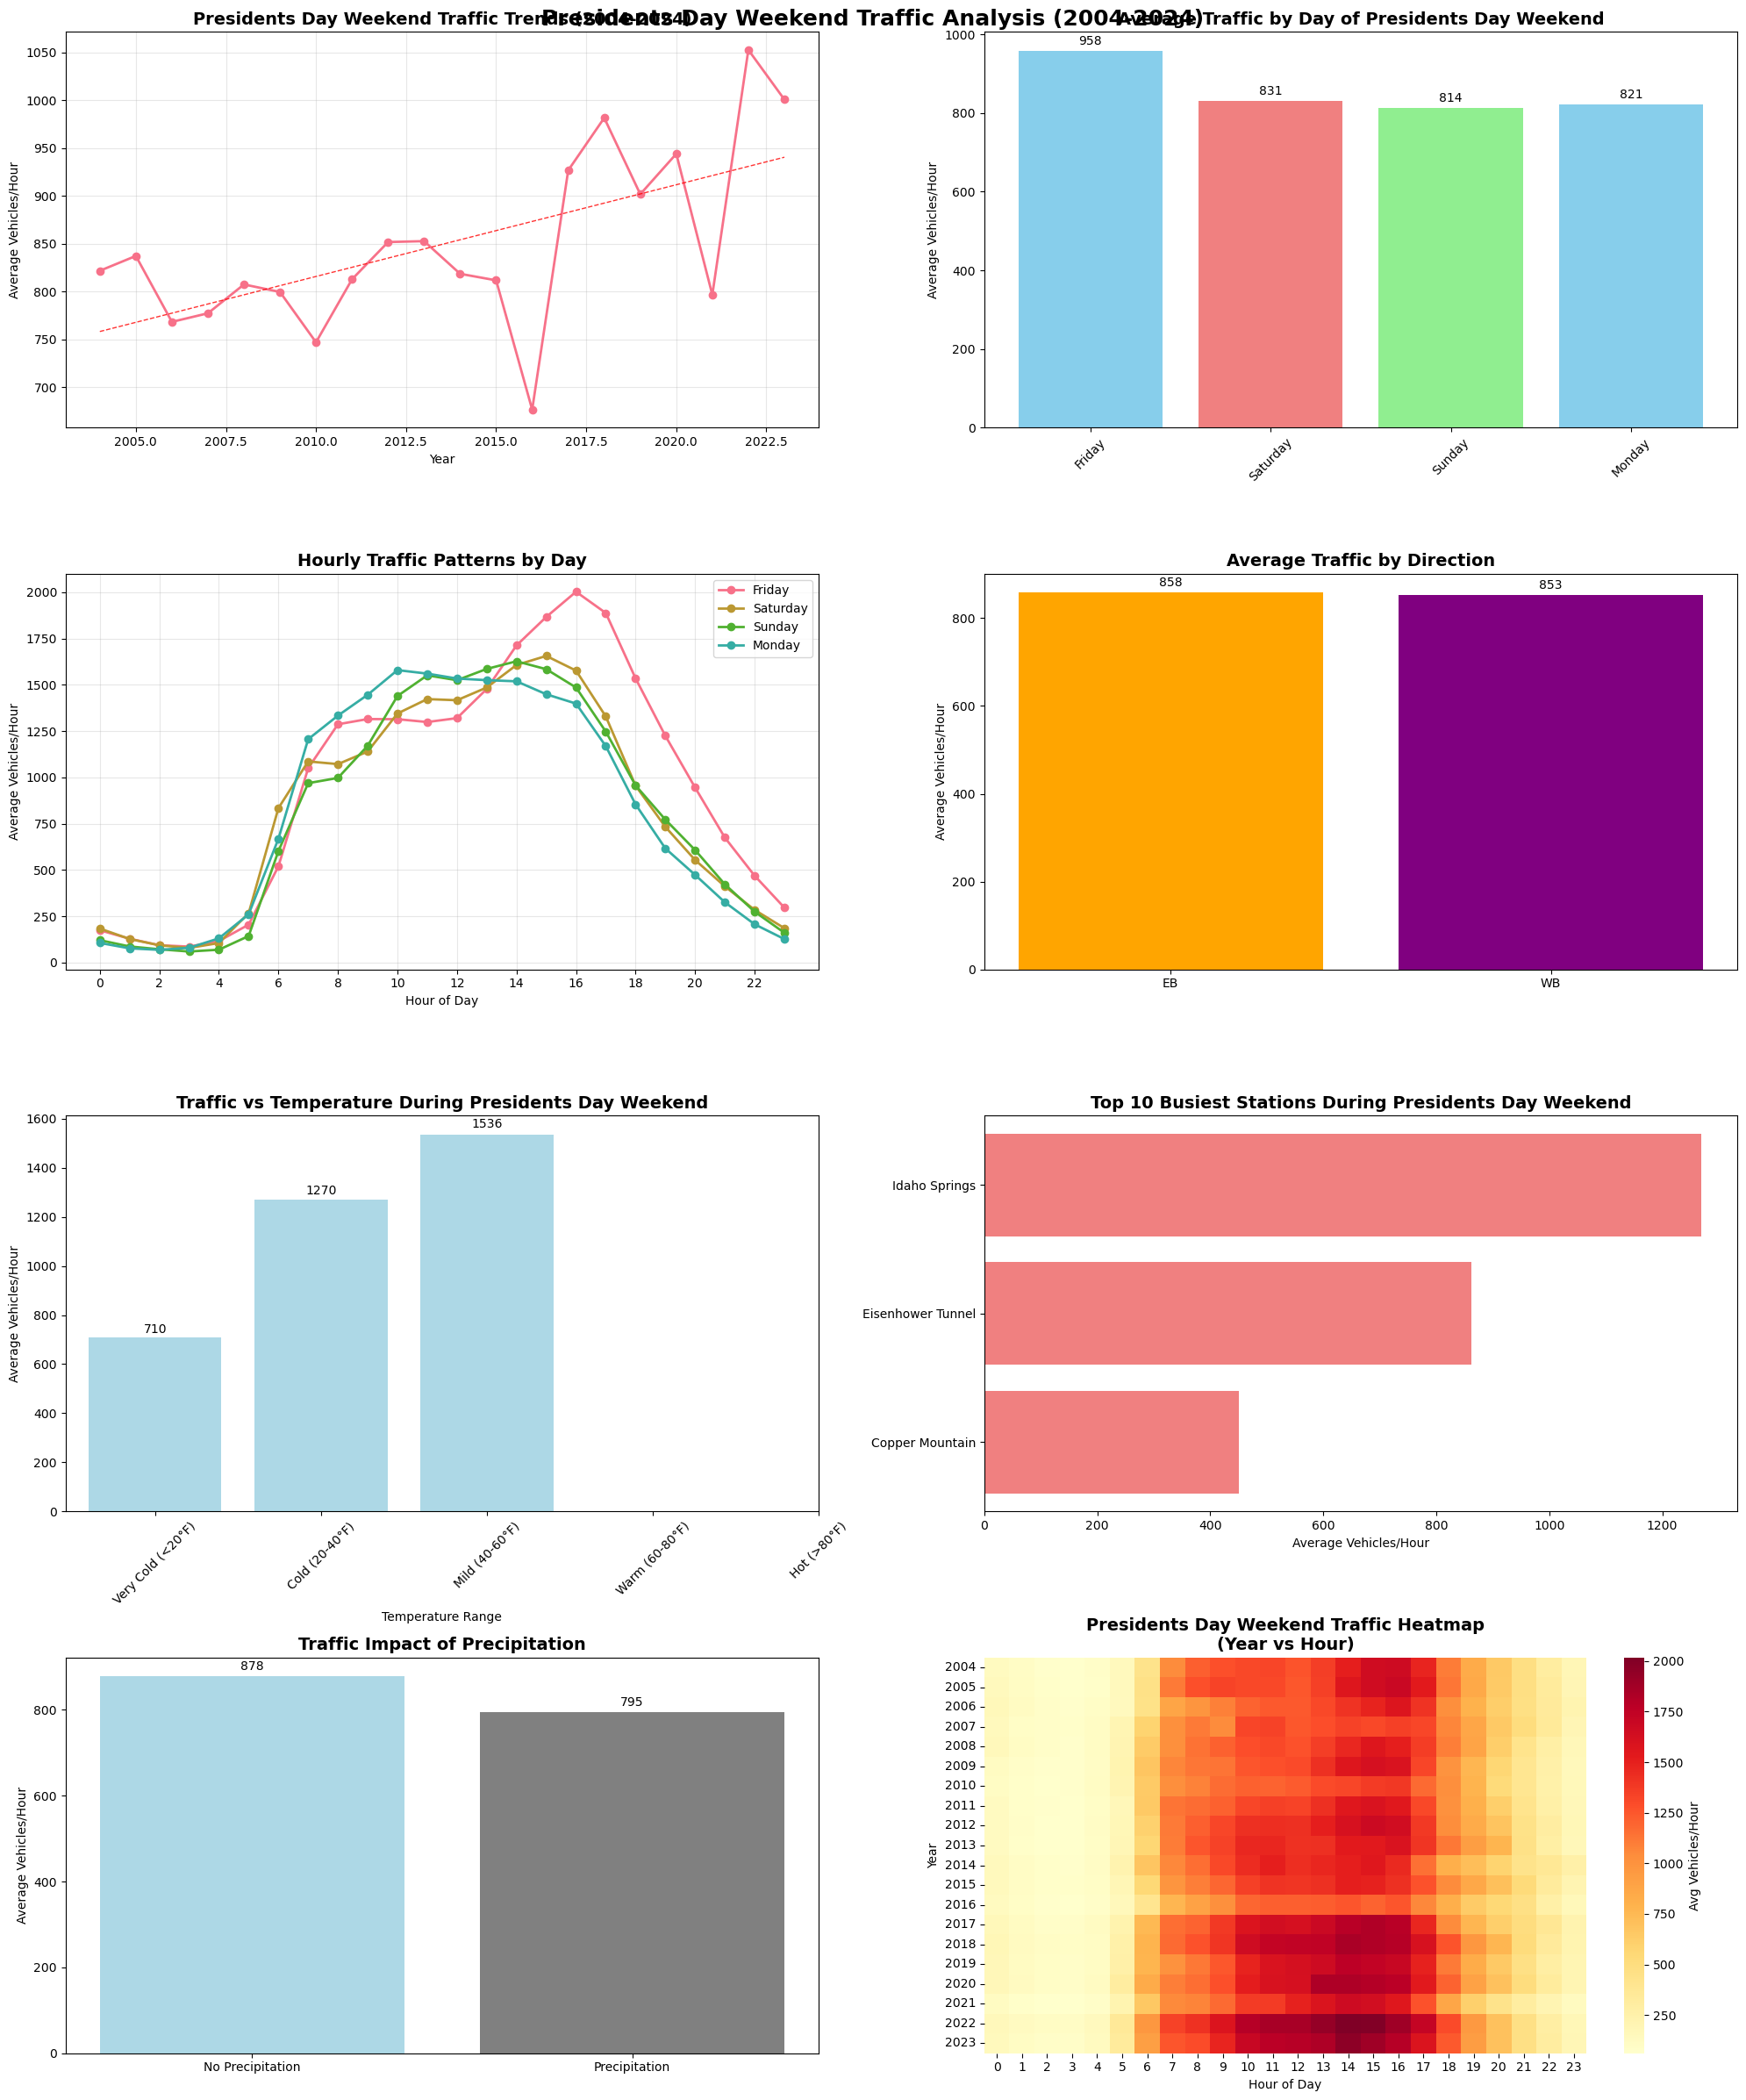


PRESIDENTS DAY WEEKEND TRAFFIC SUMMARY

📊 OVERALL STATISTICS:
• Total records analyzed: 10,992
• Years covered: 20
• Average traffic: 855.4 vehicles/hour
• Peak traffic: 4,180 vehicles/hour
• Lowest traffic: 1 vehicles/hour

📈 YEARLY TRENDS:
• 2004 average: 821.9 vehicles/hour
• 2024 average: 1000.9 vehicles/hour
• 20-year change: +21.8%

🗓️ DAY PATTERNS:
• Friday: 958.3 vehicles/hour
• Saturday: 831.2 vehicles/hour
• Sunday: 813.7 vehicles/hour
• Monday: 821.4 vehicles/hour

🌡️ WEATHER IMPACT:
• Average temperature: 13.1°F
• Days with precipitation: 2986/10992 (27.2%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

def get_presidents_day(year):
    """
    Calculate Presidents Day (3rd Monday in February) for a given year
    """
    # Start with February 1st
    feb_1 = datetime(year, 2, 1)
    
    # Find first Monday in February
    days_to_monday = (7 - feb_1.weekday()) % 7
    first_monday = feb_1 + timedelta(days=days_to_monday)
    
    # Presidents Day is the 3rd Monday (add 14 days)
    presidents_day = first_monday + timedelta(days=14)
    
    return presidents_day

def extract_presidents_day_weekends(df):
    """
    Extract all Presidents Day weekends from the dataset
    """
    print("Extracting Presidents Day weekends (2004-2024)...")
    
    # Ensure datetime column is properly formatted
    print("Converting datetime column...")
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    print(f"✓ Datetime column converted. Range: {df['datetime'].min()} to {df['datetime'].max()}")
    
    presidents_day_data = []
    
    # Get all years in the dataset
    years = range(2004, 2024)  # 2004 to 2024
    
    for year in years:
        presidents_day = get_presidents_day(year)
        
        # Define the weekend: Saturday before, Sunday before, and Monday (Presidents Day)
        friday = presidents_day - timedelta(days=3)
        saturday = presidents_day - timedelta(days=2)
        sunday = presidents_day - timedelta(days=1)
        monday = presidents_day
        
        weekend_dates = [friday.date(), saturday.date(), sunday.date(), monday.date()]
        
        print(f"  {year}: {friday.strftime('%Feb %d')} - {monday.strftime('%Feb %d')}")
        
        # Filter data for this weekend
        weekend_data = df[df['datetime'].dt.date.isin(weekend_dates)].copy()
        
        if not weekend_data.empty:
            weekend_data['year'] = year
            weekend_data['day_of_weekend'] = weekend_data['datetime'].dt.day_name()
            weekend_data['presidents_day_date'] = presidents_day.date()
            presidents_day_data.append(weekend_data)
    
    if presidents_day_data:
        combined_data = pd.concat(presidents_day_data, ignore_index=True)
        print(f"\n✓ Found {len(combined_data):,} records across {len(years)} Presidents Day weekends")
        return combined_data
    else:
        print("❌ No Presidents Day weekend data found")
        return pd.DataFrame()

def analyze_presidents_day_traffic(df):
    """
    Comprehensive analysis of Presidents Day weekend traffic patterns
    """
    # Extract the data
    weekend_data = extract_presidents_day_weekends(df)
    
    if weekend_data.empty:
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig = plt.figure(figsize=(20, 24))
    
    # 1. YEARLY TREND ANALYSIS
    plt.subplot(4, 2, 1)
    yearly_avg = weekend_data.groupby('year')['count'].mean()
    plt.plot(yearly_avg.index, yearly_avg.values, marker='o', linewidth=2, markersize=6)
    plt.title('Presidents Day Weekend Traffic Trends (2004-2024)', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Average Vehicles/Hour')
    plt.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(yearly_avg.index, yearly_avg.values, 1)
    p = np.poly1d(z)
    plt.plot(yearly_avg.index, p(yearly_avg.index), "r--", alpha=0.8, linewidth=1)
    
    # 2. DAY-OF-WEEKEND PATTERNS
    plt.subplot(4, 2, 2)
    day_order = ['Friday', 'Saturday', 'Sunday', 'Monday']
    day_avg = weekend_data.groupby('day_of_weekend')['count'].mean().reindex(day_order)
    bars = plt.bar(day_avg.index, day_avg.values, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Average Traffic by Day of Presidents Day Weekend', fontsize=14, fontweight='bold')
    plt.ylabel('Average Vehicles/Hour')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 3. HOURLY PATTERNS BY DAY
    plt.subplot(4, 2, 3)
    for day in day_order:
        day_data = weekend_data[weekend_data['day_of_weekend'] == day]
        hourly_avg = day_data.groupby('hour')['count'].mean()
        plt.plot(hourly_avg.index, hourly_avg.values, marker='o', label=day, linewidth=2)
    
    plt.title('Hourly Traffic Patterns by Day', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Vehicles/Hour')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24, 2))
    
    # 4. TRAFFIC DIRECTION COMPARISON
    plt.subplot(4, 2, 4)
    direction_avg = weekend_data.groupby('COUNTDIR')['count'].mean()
    bars = plt.bar(direction_avg.index, direction_avg.values, color=['orange', 'purple'])
    plt.title('Average Traffic by Direction', fontsize=14, fontweight='bold')
    plt.ylabel('Average Vehicles/Hour')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 5. WEATHER IMPACT ANALYSIS
    plt.subplot(4, 2, 5)
    # Create temperature bins
    weekend_data['temp_bin'] = pd.cut(weekend_data['temp'], 
                                     bins=[-50, 20, 40, 60, 80, 100], 
                                     labels=['Very Cold (<20°F)', 'Cold (20-40°F)', 
                                            'Mild (40-60°F)', 'Warm (60-80°F)', 'Hot (>80°F)'])
    
    temp_traffic = weekend_data.groupby('temp_bin')['count'].mean()
    bars = plt.bar(range(len(temp_traffic)), temp_traffic.values, color='lightblue')
    plt.title('Traffic vs Temperature During Presidents Day Weekend', fontsize=14, fontweight='bold')
    plt.xlabel('Temperature Range')
    plt.ylabel('Average Vehicles/Hour')
    plt.xticks(range(len(temp_traffic)), temp_traffic.index, rotation=45)
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if not np.isnan(height):
            plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:.0f}', ha='center', va='bottom')
    
    # 6. TOP TRAFFIC STATIONS
    plt.subplot(4, 2, 6)
    station_avg = weekend_data.groupby('station_name')['count'].mean().sort_values(ascending=False).head(10)
    bars = plt.barh(range(len(station_avg)), station_avg.values, color='lightcoral')
    plt.title('Top 10 Busiest Stations During Presidents Day Weekend', fontsize=14, fontweight='bold')
    plt.xlabel('Average Vehicles/Hour')
    plt.yticks(range(len(station_avg)), station_avg.index)
    plt.gca().invert_yaxis()
    
    # 7. PRECIPITATION IMPACT
    plt.subplot(4, 2, 7)
    weekend_data['has_precip'] = (weekend_data['precipitation'] > 0).map({True: 'Precipitation', False: 'No Precipitation'})
    precip_traffic = weekend_data.groupby('has_precip')['count'].mean()
    bars = plt.bar(precip_traffic.index, precip_traffic.values, color=['lightblue', 'gray'])
    plt.title('Traffic Impact of Precipitation', fontsize=14, fontweight='bold')
    plt.ylabel('Average Vehicles/Hour')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.0f}', ha='center', va='bottom')
    
    # 8. YEAR-BY-YEAR HEATMAP
    plt.subplot(4, 2, 8)
    yearly_hourly = weekend_data.groupby(['year', 'hour'])['count'].mean().unstack(fill_value=0)
    sns.heatmap(yearly_hourly, cmap='YlOrRd', cbar_kws={'label': 'Avg Vehicles/Hour'})
    plt.title('Presidents Day Weekend Traffic Heatmap\n(Year vs Hour)', fontsize=14, fontweight='bold')
    plt.xlabel('Hour of Day')
    plt.ylabel('Year')
    
    plt.tight_layout()
    plt.suptitle('Presidents Day Weekend Traffic Analysis (2004-2024)', 
                fontsize=18, fontweight='bold', y=0.995)
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*70)
    print("PRESIDENTS DAY WEEKEND TRAFFIC SUMMARY")
    print("="*70)
    
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"• Total records analyzed: {len(weekend_data):,}")
    print(f"• Years covered: {weekend_data['year'].nunique()}")
    print(f"• Average traffic: {weekend_data['count'].mean():.1f} vehicles/hour")
    print(f"• Peak traffic: {weekend_data['count'].max():,} vehicles/hour")
    print(f"• Lowest traffic: {weekend_data['count'].min():,} vehicles/hour")
    
    print(f"\n📈 YEARLY TRENDS:")
    first_year_avg = yearly_avg.iloc[0]
    last_year_avg = yearly_avg.iloc[-1]
    change = ((last_year_avg - first_year_avg) / first_year_avg) * 100
    print(f"• 2004 average: {first_year_avg:.1f} vehicles/hour")
    print(f"• 2024 average: {last_year_avg:.1f} vehicles/hour")
    print(f"• 20-year change: {change:+.1f}%")
    
    print(f"\n🗓️ DAY PATTERNS:")
    for day in day_order:
        avg = day_avg[day]
        print(f"• {day}: {avg:.1f} vehicles/hour")
    
    print(f"\n🌡️ WEATHER IMPACT:")
    if not weekend_data['temp'].isna().all():
        print(f"• Average temperature: {weekend_data['temp'].mean():.1f}°F")
        if 'has_precip' in weekend_data.columns:
            precip_days = (weekend_data['precipitation'] > 0).sum()
            total_days = len(weekend_data['precipitation'].dropna())
            print(f"• Days with precipitation: {precip_days}/{total_days} ({precip_days/total_days*100:.1f}%)")
    
    return weekend_data

# Usage:
weekend_data = analyze_presidents_day_traffic(df)

# Presidents Day vs Average February Weekend

PRESIDENTS DAY vs AVERAGE WEEKEND COMPARISON
Extracting Presidents Day weekends...
✓ Found 10,992 records from 20 Presidents Day weekends
Extracting average February weekends...
  2004: Added average weekend (2004-02-06eb 06 - 2004-02-09eb 09)
  2004: Skipping Presidents Day weekend (2004-02-13eb 13 - 2004-02-16eb 16)
  2004: Added average weekend (2004-02-20eb 20 - 2004-02-23eb 23)
  2005: Added average weekend (2005-02-04eb 04 - 2005-02-07eb 07)
  2005: Added average weekend (2005-02-11eb 11 - 2005-02-14eb 14)
  2005: Skipping Presidents Day weekend (2005-02-18eb 18 - 2005-02-21eb 21)
  2005: Added average weekend (2005-02-25eb 25 - 2005-02-28eb 28)
  2006: Added average weekend (2006-02-03eb 03 - 2006-02-06eb 06)
  2006: Added average weekend (2006-02-10eb 10 - 2006-02-13eb 13)
  2006: Skipping Presidents Day weekend (2006-02-17eb 17 - 2006-02-20eb 20)
  2006: Added average weekend (2006-02-24eb 24 - 2006-02-27eb 27)
  2007: Added average weekend (2007-02-02eb 02 - 2007-02-05eb 05)


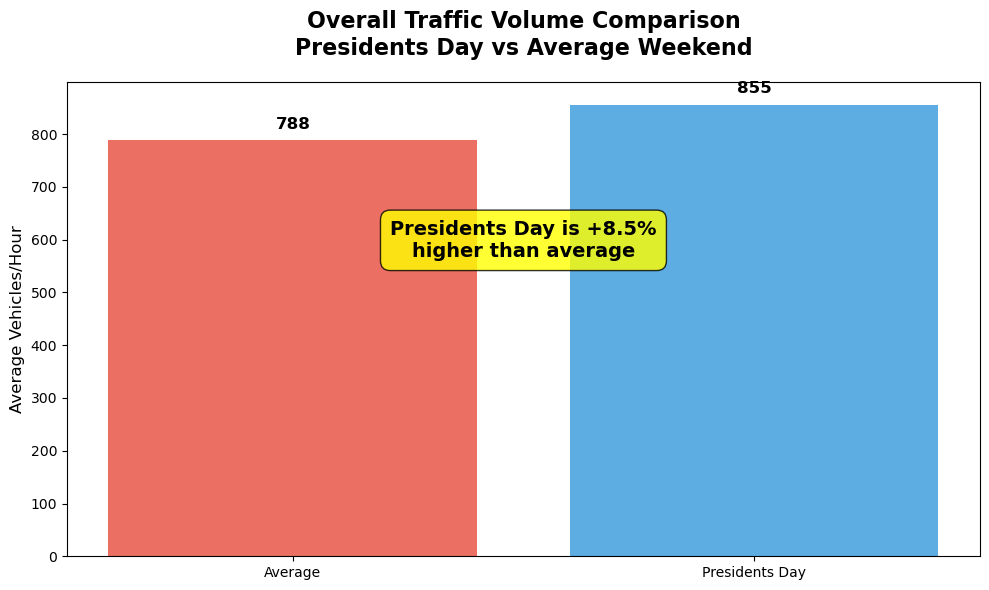

<Figure size 1200x600 with 0 Axes>

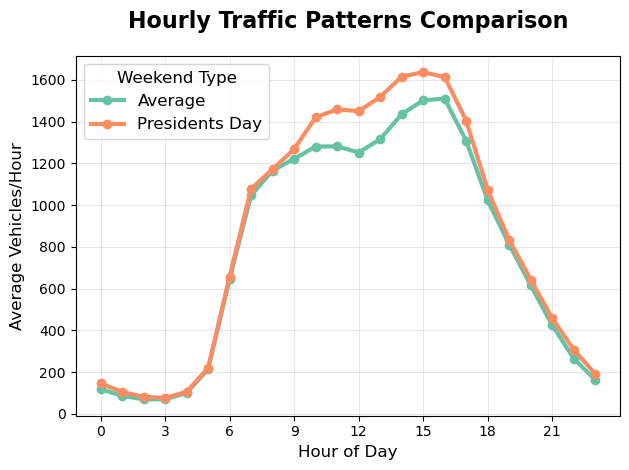

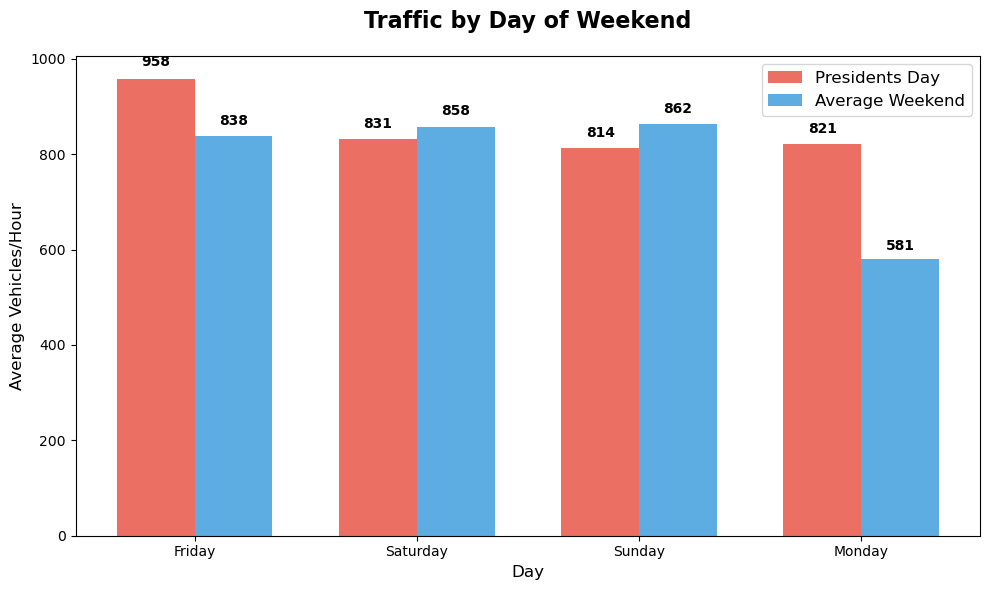

<Figure size 1200x600 with 0 Axes>

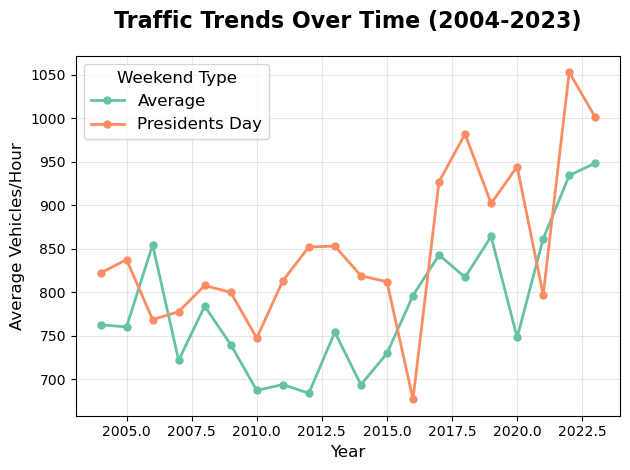

<Figure size 1200x800 with 0 Axes>

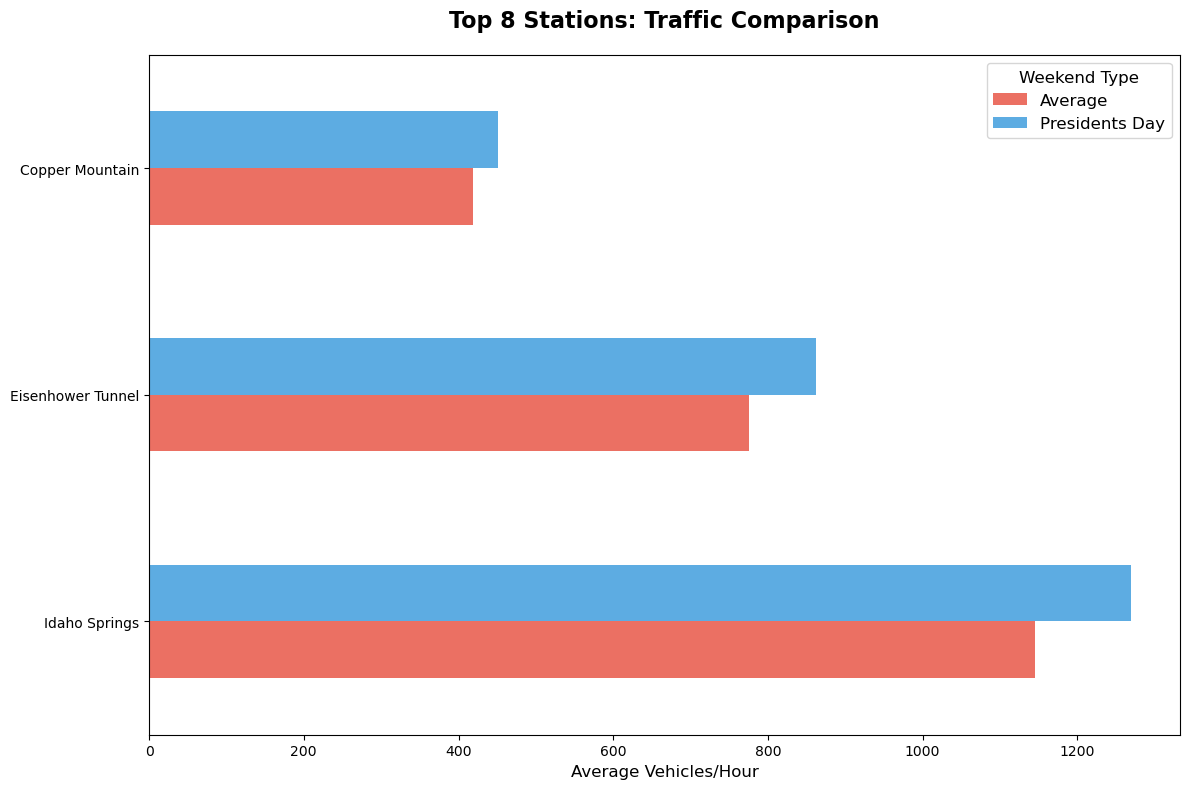


DETAILED COMPARISON STATISTICS

📊 VOLUME COMPARISON:
• Presidents Day average: 855.4 vehicles/hour
• Average weekend: 788.4 vehicles/hour
• Difference: +8.5% (busier on Presidents Day)

🕐 PEAK HOUR ANALYSIS:
• Presidents Day peak: 1637 vehicles/hour at 15:00
• Average weekend peak: 1510 vehicles/hour at 16:00

📈 DAY-BY-DAY BREAKDOWN:
• Friday: Presidents Day 958 vs Average 838 (+14.4%)
• Saturday: Presidents Day 831 vs Average 858 (-3.1%)
• Sunday: Presidents Day 814 vs Average 862 (-5.6%)
• Monday: Presidents Day 821 vs Average 581 (+41.4%)

🧮 STATISTICAL SUMMARY:
• Presidents Day - Median: 612, Std: 832
• Average Weekend - Median: 559, Std: 792


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

def get_presidents_day(year):
    """Calculate Presidents Day (3rd Monday in February) for a given year"""
    feb_1 = datetime(year, 2, 1)
    days_to_monday = (7 - feb_1.weekday()) % 7
    first_monday = feb_1 + timedelta(days=days_to_monday)
    presidents_day = first_monday + timedelta(days=14)
    return presidents_day

def extract_average_february_weekends(df):
    """
    Extract average February weekends (excluding Presidents Day weekend)
    """
    print("Extracting average February weekends...")
    
    # Ensure datetime column is properly formatted
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    average_weekend_data = []
    years = range(2004, 2024)
    
    for year in years:
        presidents_day = get_presidents_day(year)
        presidents_friday = presidents_day - timedelta(days=3)
        presidents_monday = presidents_day
        
        # Get all February weekends for this year
        feb_start = datetime(year, 2, 1)
        feb_end = datetime(year, 2, 28) if year % 4 != 0 else datetime(year, 2, 29)
        
        # Find all Fridays in February
        current_date = feb_start
        while current_date <= feb_end:
            if current_date.weekday() == 4:  # Friday
                friday = current_date
                saturday = friday + timedelta(days=1)
                sunday = friday + timedelta(days=2)
                monday = friday + timedelta(days=3)
                
                # Skip Presidents Day weekend
                if friday.date() == presidents_friday.date():
                    print(f"  {year}: Skipping Presidents Day weekend ({friday.strftime('%Feb %d')} - {monday.strftime('%Feb %d')})")
                    current_date += timedelta(days=7)
                    continue
                
                # Skip if weekend extends into March
                if monday.month != 2:
                    current_date += timedelta(days=7)
                    continue
                
                weekend_dates = [friday.date(), saturday.date(), sunday.date(), monday.date()]
                weekend_data = df[df['datetime'].dt.date.isin(weekend_dates)].copy()
                
                if not weekend_data.empty:
                    weekend_data['year'] = year
                    weekend_data['weekend_type'] = 'Average'
                    weekend_data['day_of_weekend'] = weekend_data['datetime'].dt.day_name()
                    weekend_data['weekend_start_date'] = friday.date()
                    average_weekend_data.append(weekend_data)
                    print(f"  {year}: Added average weekend ({friday.strftime('%Feb %d')} - {monday.strftime('%Feb %d')})")
            
            current_date += timedelta(days=1)
    
    if average_weekend_data:
        combined_data = pd.concat(average_weekend_data, ignore_index=True)
        print(f"✓ Found {len(combined_data):,} records from {len(average_weekend_data)} average February weekends")
        return combined_data
    else:
        print("❌ No average weekend data found")
        return pd.DataFrame()

def extract_presidents_day_weekends_for_comparison(df):
    """Extract Presidents Day weekends with consistent format for comparison"""
    print("Extracting Presidents Day weekends...")
    
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    presidents_day_data = []
    years = range(2004, 2024)
    
    for year in years:
        presidents_day = get_presidents_day(year)
        friday = presidents_day - timedelta(days=3)
        saturday = presidents_day - timedelta(days=2)
        sunday = presidents_day - timedelta(days=1)
        monday = presidents_day
        
        weekend_dates = [friday.date(), saturday.date(), sunday.date(), monday.date()]
        weekend_data = df[df['datetime'].dt.date.isin(weekend_dates)].copy()
        
        if not weekend_data.empty:
            weekend_data['year'] = year
            weekend_data['weekend_type'] = 'Presidents Day'
            weekend_data['day_of_weekend'] = weekend_data['datetime'].dt.day_name()
            weekend_data['weekend_start_date'] = friday.date()
            presidents_day_data.append(weekend_data)
    
    if presidents_day_data:
        combined_data = pd.concat(presidents_day_data, ignore_index=True)
        print(f"✓ Found {len(combined_data):,} records from {len(presidents_day_data)} Presidents Day weekends")
        return combined_data
    else:
        print("❌ No Presidents Day weekend data found")
        return pd.DataFrame()

def compare_presidents_day_vs_average_weekends(df):
    """
    Comprehensive comparison of Presidents Day weekends vs average February weekends
    """
    print("=" * 70)
    print("PRESIDENTS DAY vs AVERAGE WEEKEND COMPARISON")
    print("=" * 70)
    
    # Extract both datasets
    presidents_data = extract_presidents_day_weekends_for_comparison(df)
    average_data = extract_average_february_weekends(df)
    
    if presidents_data.empty or average_data.empty:
        print("❌ Cannot compare - missing data")
        return
    
    # Combine datasets
    combined_data = pd.concat([presidents_data, average_data], ignore_index=True)
    
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("Set2")
    
    # 1. OVERALL TRAFFIC VOLUME COMPARISON
    plt.figure(figsize=(10, 6))
    volume_comparison = combined_data.groupby('weekend_type')['count'].mean()
    bars = plt.bar(volume_comparison.index, volume_comparison.values, 
                   color=['#e74c3c', '#3498db'], alpha=0.8)
    plt.title('Overall Traffic Volume Comparison\nPresidents Day vs Average Weekend', 
              fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Average Vehicles/Hour', fontsize=12)
    
    # Add percentage difference
    pres_day_avg = volume_comparison['Presidents Day']
    avg_weekend_avg = volume_comparison['Average']
    pct_diff = ((pres_day_avg - avg_weekend_avg) / avg_weekend_avg) * 100
    
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
                f'{height:.0f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.text(0.5, max(volume_comparison.values) * 0.7, 
             f'Presidents Day is {pct_diff:+.1f}%\n{"higher" if pct_diff > 0 else "lower"} than average',
             ha='center', va='center', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 2. HOURLY PATTERNS COMPARISON
    plt.figure(figsize=(12, 6))
    hourly_comparison = combined_data.groupby(['weekend_type', 'hour'])['count'].mean().unstack(level=0)
    hourly_comparison.plot(kind='line', marker='o', linewidth=3, markersize=6)
    plt.title('Hourly Traffic Patterns Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Average Vehicles/Hour', fontsize=12)
    plt.legend(title='Weekend Type', fontsize=12, title_fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24, 3), fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # 3. DAY-OF-WEEKEND COMPARISON
    plt.figure(figsize=(10, 6))
    day_order = ['Friday', 'Saturday', 'Sunday', 'Monday']
    day_comparison = combined_data.groupby(['weekend_type', 'day_of_weekend'])['count'].mean().unstack(level=0)
    day_comparison = day_comparison.reindex(day_order)
    
    x = np.arange(len(day_order))
    width = 0.35
    
    plt.bar(x - width/2, day_comparison['Presidents Day'], width, 
            label='Presidents Day', color='#e74c3c', alpha=0.8)
    plt.bar(x + width/2, day_comparison['Average'], width, 
            label='Average Weekend', color='#3498db', alpha=0.8)
    
    plt.title('Traffic by Day of Weekend', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Day', fontsize=12)
    plt.ylabel('Average Vehicles/Hour', fontsize=12)
    plt.xticks(x, day_order)
    plt.legend(fontsize=12)
    
    # Add value labels
    for i, day in enumerate(day_order):
        pres_val = day_comparison.loc[day, 'Presidents Day']
        avg_val = day_comparison.loc[day, 'Average']
        plt.text(i - width/2, pres_val + pres_val*0.02, f'{pres_val:.0f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
        plt.text(i + width/2, avg_val + avg_val*0.02, f'{avg_val:.0f}', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 4. YEARLY TRENDS COMPARISON
    plt.figure(figsize=(12, 6))
    yearly_trends = combined_data.groupby(['year', 'weekend_type'])['count'].mean().unstack(level=1)
    yearly_trends.plot(kind='line', marker='o', linewidth=2, markersize=5)
    plt.title('Traffic Trends Over Time (2004-2023)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Vehicles/Hour', fontsize=12)
    plt.legend(title='Weekend Type', fontsize=12, title_fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 5. TOP STATIONS COMPARISON
    plt.figure(figsize=(12, 8))
    station_comparison = combined_data.groupby(['station_name', 'weekend_type'])['count'].mean().unstack(level=1)
    top_stations = station_comparison.mean(axis=1).nlargest(8).index
    station_comparison_top = station_comparison.loc[top_stations]
    
    # Truncate long station names for readability
    station_names_short = [name[:30] + '...' if len(name) > 30 else name for name in station_comparison_top.index]
    station_comparison_top.index = station_names_short
    
    station_comparison_top.plot(kind='barh', color=['#e74c3c', '#3498db'], alpha=0.8, figsize=(12, 8))
    plt.title('Top 8 Stations: Traffic Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Average Vehicles/Hour', fontsize=12)
    plt.legend(title='Weekend Type', fontsize=12, title_fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED COMPARISON STATISTICS")
    print("="*70)
    
    print(f"\n📊 VOLUME COMPARISON:")
    print(f"• Presidents Day average: {pres_day_avg:.1f} vehicles/hour")
    print(f"• Average weekend: {avg_weekend_avg:.1f} vehicles/hour")
    print(f"• Difference: {pct_diff:+.1f}% ({'busier' if pct_diff > 0 else 'quieter'} on Presidents Day)")
    
    # Find peak hours
    peak_hours_pres = combined_data[combined_data['weekend_type'] == 'Presidents Day'].groupby('hour')['count'].mean()
    peak_hours_avg = combined_data[combined_data['weekend_type'] == 'Average'].groupby('hour')['count'].mean()
    
    peak_hour_pres = peak_hours_pres.idxmax()
    peak_hour_avg = peak_hours_avg.idxmax()
    peak_traffic_pres = peak_hours_pres.max()
    peak_traffic_avg = peak_hours_avg.max()
    
    print(f"\n🕐 PEAK HOUR ANALYSIS:")
    print(f"• Presidents Day peak: {peak_traffic_pres:.0f} vehicles/hour at {peak_hour_pres}:00")
    print(f"• Average weekend peak: {peak_traffic_avg:.0f} vehicles/hour at {peak_hour_avg}:00")
    
    print(f"\n📈 DAY-BY-DAY BREAKDOWN:")
    for day in day_order:
        pres_val = day_comparison.loc[day, 'Presidents Day']
        avg_val = day_comparison.loc[day, 'Average']
        day_diff = ((pres_val - avg_val) / avg_val) * 100
        print(f"• {day}: Presidents Day {pres_val:.0f} vs Average {avg_val:.0f} ({day_diff:+.1f}%)")
    
    print(f"\n🧮 STATISTICAL SUMMARY:")
    pres_stats = combined_data[combined_data['weekend_type'] == 'Presidents Day']['count']
    avg_stats = combined_data[combined_data['weekend_type'] == 'Average']['count']
    
    print(f"• Presidents Day - Median: {pres_stats.median():.0f}, Std: {pres_stats.std():.0f}")
    print(f"• Average Weekend - Median: {avg_stats.median():.0f}, Std: {avg_stats.std():.0f}")
    
    return combined_data

# Usage:
comparison_data = compare_presidents_day_vs_average_weekends(df)

In [ ]:
# STEP 1: Train Your Model 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load your processed data
df = pd.read_csv('combined_data_imputed.csv')

print(f"Training on {len(df)} records")

# Prepare features and target
feature_columns = [
    'Hour', 'Month', 'DayOfWeek', 
    'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)',
    'PRCP (Inches)', 'SNWD (Inches)'
]

# Handle categorical direction
df['COUNTDIR_EB'] = (df['COUNTDIR'] == 'EB').astype(int)

# Final feature set
X_features = feature_columns + ['COUNTDIR_EB']
X = df[X_features]
y = df['TrafficVolume (per hour)']

# Remove any remaining missing values
mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

print(f"Training on {len(X)} clean records")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

print("Training model...")
model.fit(X_train, y_train)

# Evaluate model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(f"Training MAE: {mean_absolute_error(y_train, train_pred):.1f}")
print(f"Test MAE: {mean_absolute_error(y_test, test_pred):.1f}")
print(f"Test R²: {r2_score(y_test, test_pred):.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance.head(10))

# Save the trained model
joblib.dump(model, 'i70_traffic_model.pkl')
joblib.dump(X.columns.tolist(), 'model_features.pkl')
print("\nModel saved as 'i70_traffic_model.pkl'")

# STEP 2: Create Prediction API (Python Flask)
"""
# app.py - Simple Flask API for your model
from flask import Flask, request, jsonify
from flask_cors import CORS
import joblib
import numpy as np

app = Flask(__name__)
CORS(app)  # Allow requests from your web app

# Load trained model
model = joblib.load('i70_traffic_model.pkl')
feature_names = joblib.load('model_features.pkl')

@app.route('/predict', methods=['POST'])
def predict_traffic():
    try:
        data = request.json
        
        # Create feature vector in correct order
        features = [
            data['hour'],
            data['month'], 
            data['dayOfWeek'],
            data['tavg'],
            data['tmax'],
            data['tmin'],
            data['prcp'],
            data['snwd'],
            1 if data['direction'] == 'EB' else 0  # COUNTDIR_EB
        ]
        
        # Make prediction
        prediction = model.predict([features])[0]
        prediction = max(0, round(prediction))  # Ensure non-negative
        
        # Add confidence interval (optional)
        # predictions = [model.predict([features])[0] for _ in range(100)]  # Bootstrap
        # confidence_interval = np.percentile(predictions, [25, 75])
        
        return jsonify({
            'trafficVolume': prediction,
            'success': True
        })
        
    except Exception as e:
        return jsonify({'error': str(e), 'success': False}), 400

if __name__ == '__main__':
    app.run(debug=True, port=5000)
"""

# STEP 3: Integrate with Web App
"""
Replace the predictTraffic function in your React app with:

const predictTraffic = async (data) => {
  setLoading(true);
  
  try {
    const response = await fetch('http://localhost:5000/predict', {
      method: 'POST',
      headers: {
        'Content-Type': 'application/json',
      },
      body: JSON.stringify(data),
    });
    
    const result = await response.json();
    
    if (result.success) {
      const trafficVolume = result.trafficVolume;
      
      // Determine congestion level
      let congestionLevel = 'Normal';
      let congestionColor = 'green';
      if (trafficVolume > 180) {
        congestionLevel = 'Severe';
        congestionColor = 'red';
      } else if (trafficVolume > 140) {
        congestionLevel = 'Heavy';
        congestionColor = 'orange';  
      } else if (trafficVolume > 110) {
        congestionLevel = 'Moderate';
        congestionColor = 'yellow';
      }
      
      setPrediction({
        trafficVolume,
        congestionLevel,
        congestionColor,
        // ... other fields
      });
    }
  } catch (error) {
    console.error('Prediction error:', error);
  }
  
  setLoading(false);
};
"""

print("\n🚀 INTEGRATION COMPLETE!")
print("Your trained model is now powering the web app!")

Training on 1006398 records


KeyError: "['Hour', 'TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNWD (Inches)'] not in index"

# This is the part where I try and do predictive modeling using Linear Regression.
- I'm not super sure what I'm doing, but I get the addition of features and such and why I need to use the OneHotEncoder to ensure each day exists as a true or false based upon the day of week, as opposed to being a 0-6
- I have hour an day as interaction terms. I'm trying to best understand what is happening, but after dropping the hour column my VIF values improved upon greatly.
## Major questions.
- <img src ="https://i.imgflip.com/9iemtt.jpg">
- is my r^2 good enough?
- What the fuck am I doing?


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import matplotlib.pyplot as plt
import holidays

# Create new features
combined_data['IsWeekend'] = combined_data['DayOfWeek'].isin([4, 5, 6]).astype(int)
us_holidays = holidays.US()
combined_data['IsHoliday'] = combined_data['Date'].apply(lambda x: x in us_holidays).astype(int)
combined_data['PrevHourTraffic'] = combined_data['TrafficVolume (per hour)'].shift(1).fillna(0)

# Define initial features
features = ['Hour', 'Month', 'DayOfWeek', 'TAVG (Degrees Fahrenheit)', 'PRCP (Inches)', 'IsHoliday', 'PrevHourTraffic']
X = combined_data[features]
y = combined_data['TrafficVolume (per hour)']

# One-hot encode DayOfWeek
encoder = OneHotEncoder(sparse=False)
day_encoded = encoder.fit_transform(combined_data[['DayOfWeek']])
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['DayOfWeek']), index=combined_data.index)
X = pd.concat([X.drop(columns='DayOfWeek'), day_encoded_df], axis=1)

# Create interaction terms for Hour and DayOfWeek
for day in day_encoded_df.columns:
    X[f'Hour_{day}'] = X['Hour'] * X[day]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save unscaled X_test for visualization
X_test_unscaled = X_test.copy()
# Drop Hour to reduce multicollinearity
X = X.drop(columns=['Hour'])

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Get coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions vs actual
plt.scatter(X_test_unscaled['Hour'], y_test, color='blue', label='Actual')
plt.scatter(X_test_unscaled['Hour'], y_pred, color='red', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


print("Number of features in X:", len(X.columns))
print("Number of coefficients in model:", len(model.coef_))




# Trying to use ridge regression

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Create simple features first
combined_data['IsWeekend'] = combined_data['DayOfWeek'].isin([4, 5, 6]).astype(int)
combined_data['IsHoliday'] = combined_data['Date'].apply(lambda x: x in us_holidays).astype(int)

# Start with SIMPLE features - no interactions yet
features = ['Hour', 'Month', 'TAVG (Degrees Fahrenheit)', 'PRCP (Inches)', 'IsHoliday', 'IsWeekend']
X = combined_data[features]
y = combined_data['TrafficVolume (per hour)']

# Split FIRST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train with Ridge
model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)
print("Ridge R²:", r2_score(y_test, y_pred))
print("Ridge Coefficients:", model.coef_)




In [ ]:
# Add back PrevHourTraffic - this is probably your strongest predictor
combined_data['PrevHourTraffic'] = combined_data['TrafficVolume (per hour)'].shift(1).fillna(0)

# Encode day of week
encoder = OneHotEncoder(sparse=False, drop='first')
day_encoded = encoder.fit_transform(combined_data[['DayOfWeek']])
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['DayOfWeek']), index=combined_data.index)

# Include PrevHourTraffic
features = ['Hour', 'Month', 'TAVG (Degrees Fahrenheit)', 'PRCP (Inches)', 'IsHoliday', 'PrevHourTraffic']
X = pd.concat([combined_data[features], day_encoded_df], axis=1)
y = combined_data['TrafficVolume (per hour)']

# Same process
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
print("Ridge R² with PrevHourTraffic:", r2_score(y_test, y_pred))
print("Coefficients:", model.coef_)

# Fucking around with other features.

In [ ]:
# Create new features
combined_data['IsWeekend'] = combined_data['DayOfWeek'].isin([4, 5, 6]).astype(int)
# combined_data['IsSkiSeason'] = combined_data['Month'].isin([11, 12, 1, 2, 3, 4]).astype(int)
us_holidays = holidays.US()
combined_data['IsHoliday'] = combined_data['Date'].apply(lambda x: x in us_holidays)
combined_data["IsHoliday"] = combined_data['IsHoliday'].astype(int)
combined_data['PrevHourTraffic'] = combined_data['TrafficVolume (per hour)'].shift(1)
combined_data['PrevHourTraffic'] = combined_data['PrevHourTraffic'].fillna(0)

# Define features and target
features = ['Hour', 'Month','DayOfWeek']
X = combined_data[features]

X['Temperature'] = combined_data['TAVG (Degrees Fahrenheit)']
X['Precipitation'] = combined_data['PRCP (Inches)']
X['IsHoliday'] = combined_data['IsHoliday']

X['PrevHourTraffic'] = combined_data['PrevHourTraffic']
# Fill NaN with 0




"""# One-hot encode DayOfWeek and add it to the features
encoder = OneHotEncoder(sparse=False)
day_encoded = encoder.fit_transform(combined_data[['DayOfWeek']])
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['DayOfWeek']), index=combined_data.index)
X = pd.concat([X, day_encoded_df], axis=1)
"""

# Create interaction terms for Hour and DayOfWeek
for day in [col for col in X.columns if 'DayOfWeek_' in col]:
    X[f'Hour_{day}'] = X['Hour'] * X[day]
# Define the target variable
y = combined_data['TrafficVolume (per hour)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

numeric_features = ['Hour', 'PrevHourTraffic', 'Temperature', 'Precipitation'] + [col for col in X.columns if 'Hour_DayOfWeek_' in col]

scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])
"""
# Initialize and train the Ridge regression model
ridge_model = Ridge(alpha=1.0)  # Adjust alpha to control regularization strength
ridge_model.fit(X_train_scaled, y_train)

# Evaluate Ridge model
ridge_y_pred = ridge_model.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_r2 = r2_score(y_test, ridge_y_pred)

print("Ridge Mean Squared Error:", ridge_mse)
print("Ridge R-squared:", ridge_r2)
"""
# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Get coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions vs actual
plt.scatter(X_test['Hour'], y_test, color='blue', label='Actual')
plt.scatter(X_test['Hour'], y_pred, color='red', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()




# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(feature_importance.sort_values(by='Coefficient', ascending=False))

import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Traffic Volume')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()



## To me this looks good, though it only really got better when I added a prevous hour feature, that i'm not sure will help in trying to do the prediction i'm trying to understand.

### I'm learning more about how things work. Previous hour traffic, and day's of week have way to high of a coefficient, meaning they are might be overfitting? Multicolinearity, two or more features being too related.
I'm still learning. 

In [ ]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()


In [ ]:

# Create new features
#combined_data['IsWeekend'] = combined_data['DayOfWeek'].isin([5, 6]).astype(int)
#combined_data['IsWeekday'] = combined_data['DayOfWeek'].isin([0,1,2,3,4]).astype(int)

#combined_data['IsSkiSeason'] = combined_data['Month'].isin([11, 12, 1, 2, 3, 4]).astype(int)
us_holidays = holidays.US()
combined_data['IsHoliday'] = combined_data['Date'].apply(lambda x: x in us_holidays)
combined_data['IsHoliday'] = combined_data['IsHoliday'].astype(int)
#combined_data['PrevHourTraffic'] = combined_data['TrafficVolume (per hour)'].shift(1)
#combined_data['PrevHourTraffic'] = combined_data['PrevHourTraffic'].fillna(0)

# Define features and target

"""



X['PrevHourTraffic'] = combined_data['PrevHourTraffic']
"""


# Define base features
features = ['Hour', 'Month', 'DayOfWeek',]
X = combined_data[features]
X['IsHoliday'] = combined_data['IsHoliday']
X['Temperature'] = combined_data['TAVG (Degrees Fahrenheit)']
X['Precipitation'] = combined_data['PRCP (Inches)']

# One-hot encode DayOfWeek and COUNTDIR
encoder = OneHotEncoder(sparse=False)
day_encoded = encoder.fit_transform(combined_data[['DayOfWeek']])
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['DayOfWeek']), index=combined_data.index)


# Add one-hot encoded features to X
X = pd.concat([X, day_encoded_df], axis=1)



# Define the target variable
y = combined_data['TrafficVolume (per hour)']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Get coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Visualize predictions vs actual
# Use unscaled X_test to extract Hour for plotting
plt.scatter(X_test['Hour'], y_test, color='blue', label='Actual')
plt.scatter(X_test['Hour'], y_pred, color='red', label='Predicted')
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print(feature_importance.sort_values(by='Coefficient', ascending=False))




# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)



In [ ]:
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Create a holiday indicator using the US holiday calendar
us_holidays = holidays.US()
combined_data['IsHoliday'] = combined_data['Date'].apply(lambda x: x in us_holidays)

# Summarize traffic volume by holiday status
traffic_holiday = combined_data.groupby('IsHoliday')['TrafficVolume (per hour)'].mean().reset_index()

# Rename columns for clarity
traffic_holiday['IsHoliday'] = traffic_holiday['IsHoliday'].map({True: 'Holiday', False: 'Non-Holiday'})


# Plotting the data
plt.figure(figsize=(8, 6))
sns.barplot(x='IsHoliday', y='TrafficVolume (per hour)', data=traffic_holiday, palette='coolwarm')

# Add labels and title
plt.title("Traffic Volume: Holidays vs Non-Holidays", fontsize=16)
plt.xlabel("Day Type", fontsize=14)
plt.ylabel("Average Traffic Volume", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:


# Step 2: Group by Month and Direction
monthly_traffic = combined_data.groupby(['Month', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Step 3: Pivot Data for Plotting
traffic_pivot = monthly_traffic.pivot(index='Month', columns='COUNTDIR', values='TrafficVolume (per hour)')

# Step 4: Plot the Data
plt.figure(figsize=(12, 6))
traffic_pivot.plot(kind='bar', figsize=(12, 6))
plt.title("Average Monthly Traffic Volume by Direction")
plt.xlabel("Month")
plt.ylabel("Average Traffic Volume")
plt.xticks(ticks=range(12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
])
plt.legend(title="Direction", loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Group by TAVG (Temperature) and Direction
temp_traffic = combined_data.groupby(['TAVG (Degrees Fahrenheit)', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Plot Traffic Volume vs. Temperature
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='TAVG (Degrees Fahrenheit)', 
    y='TrafficVolume (per hour)', 
    hue='COUNTDIR', 
    data=temp_traffic
)
plt.title("Traffic Volume vs. Temperature by Direction")
plt.xlabel("Average Temperature (°F)")
plt.ylabel("Average Traffic Volume")
plt.legend(title="Direction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:

# Group by Precipitation (PRCP) and Direction
precip_traffic = combined_data.groupby(['PRCP (Inches)', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Plot Traffic Volume vs. Precipitation
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='PRCP (Inches)', 
    y='TrafficVolume (per hour)', 
    hue='COUNTDIR', 
    data=precip_traffic
)
plt.title("Traffic Volume vs. Precipitation by Direction")
plt.xlabel("Precipitation (Inches)")
plt.ylabel("Average Traffic Volume")
plt.legend(title="Direction")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# Group data by Temperature, Direction, and Hour
temp_traffic_hourly = combined_data.groupby(['TAVG (Degrees Fahrenheit)', 'COUNTDIR', 'Hour'])['TrafficVolume (per hour)'].mean().reset_index()

# Plot using Facet Grid
g = sns.FacetGrid(temp_traffic_hourly, col="Hour", hue="COUNTDIR", col_wrap=4, height=4, sharey=False)
g.map(sns.lineplot, "TAVG (Degrees Fahrenheit)", "TrafficVolume (per hour)").add_legend()
g.set_titles("Hour: {col_name}")
g.set_axis_labels("Temperature (°F)", "Traffic Volume")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Traffic Volume vs. Temperature by Hour and Direction")
plt.show()


In [ ]:
# Group data by Precipitation, Direction, and Hour
precip_traffic_hourly = combined_data.groupby(['PRCP (Inches)', 'COUNTDIR', 'Hour'])['TrafficVolume (per hour)'].mean().reset_index()

# Plot using Facet Grid
g = sns.FacetGrid(precip_traffic_hourly, col="Hour", hue="COUNTDIR", col_wrap=4, height=4, sharey=False)
g.map(sns.lineplot, "PRCP (Inches)", "TrafficVolume (per hour)").add_legend()
g.set_titles("Hour: {col_name}")
g.set_axis_labels("Precipitation (Inches)", "Traffic Volume")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Traffic Volume vs. Precipitation by Hour and Direction")
plt.show()


In [ ]:
print(combined_data[['Hour', 'COUNTDIR', 'TrafficVolume (per hour)']].groupby(['Hour', 'COUNTDIR']).mean())


In [ ]:


# Group by Hour, Precipitation, and Direction
traffic_precip_direction = combined_data.groupby(['Hour', 'PRCP (Inches)', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Sort by Hour
traffic_precip_direction = traffic_precip_direction.sort_values(by='Hour')

# Group by Hour, Precipitation, and Direction
traffic_precip_direction = combined_data.groupby(['Hour', 'PRCP (Inches)', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Create pivot tables for EB and WB
eb_data = traffic_precip_direction[traffic_precip_direction['COUNTDIR'] == 'EB'].pivot(
    index='Hour', columns='PRCP (Inches)', values='TrafficVolume (per hour)'
)
wb_data = traffic_precip_direction[traffic_precip_direction['COUNTDIR'] == 'WB'].pivot(
    index='Hour', columns='PRCP (Inches)', values='TrafficVolume (per hour)'
)

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic Volume")
axes[0].set_xlabel("Precipitation (Inches)")
axes[0].set_ylabel("Hour of Day")
axes[0].set_yticks(range(24))
axes[0].set_yticklabels(range(24))

# Westbound Traffic Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic Volume")
axes[1].set_xlabel("Precipitation (Inches)")
axes[1].set_ylabel("")  # Remove redundant label
axes[1].set_yticks(range(24))
axes[1].set_yticklabels(range(24))

plt.tight_layout()
plt.show()



In [ ]:
# Group by Hour and Direction
traffic_hour_direction = combined_data.groupby(['Hour', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Create Pivot Table
hourly_traffic = traffic_hour_direction.pivot(index='Hour', columns='COUNTDIR', values='TrafficVolume (per hour)')

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(hourly_traffic[['EB']], cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic Volume by Hour")
axes[0].set_xlabel("Eastbound")
axes[0].set_ylabel("Hour of Day")
axes[0].set_yticks(range(24))
axes[0].set_yticklabels(range(24))

# Westbound Traffic Heatmap
sns.heatmap(hourly_traffic[['WB']], cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic Volume by Hour")
axes[1].set_xlabel("Westbound")
axes[1].set_ylabel("")  # Remove redundant label
axes[1].set_yticks(range(24))
axes[1].set_yticklabels(range(24))

plt.tight_layout()
plt.show()

In [ ]:
traffic_month_hour = combined_data.groupby(['Month', 'Hour', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Create Pivot Tables for EB and WB traffic
eb_data = traffic_month_hour[traffic_month_hour['COUNTDIR'] == 'EB'].pivot(
    index='Hour', columns='Month', values='TrafficVolume (per hour)'
)
wb_data = traffic_month_hour[traffic_month_hour['COUNTDIR'] == 'WB'].pivot(
    index='Hour', columns='Month', values='TrafficVolume (per hour)'
)

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic Volume by Hour and Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Hour of Day")
axes[0].set_yticks(range(24))
axes[0].set_yticklabels(range(24))
axes[0].set_xticks(range(1, 13))  # Set x-ticks for 12 months
axes[0].set_xticklabels(calendar.month_abbr[1:])  # Use abbreviated month names (Jan, Feb, ...)

# Westbound Traffic Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic Volume by Hour and Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("")  # Remove redundant label
axes[1].set_yticks(range(24))
axes[1].set_yticklabels(range(24))
axes[1].set_xticks(range(1, 13))  # Set x-ticks for 12 months
axes[1].set_xticklabels(calendar.month_abbr[1:])  # Use abbreviated month names (Jan, Feb, ...)
    

plt.tight_layout()
plt.show()


In [ ]:

# Create Pivot Tables for EB and WB traffic
eb_data = traffic_month_hour[traffic_month_hour['COUNTDIR'] == 'EB'].pivot(
    index='Hour', columns='Month', values='TrafficVolume (per hour)'
)
wb_data = traffic_month_hour[traffic_month_hour['COUNTDIR'] == 'WB'].pivot(
    index='Hour', columns='Month', values='TrafficVolume (per hour)'
)

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic Volume by Hour and Month")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Hour of Day")
axes[0].set_yticks(range(24))
axes[0].set_yticklabels(range(24))
axes[0].set_xticks(range(1, 13))  # Set x-ticks for 12 months
axes[0].set_xticklabels(calendar.month_abbr[1:])  # Use abbreviated month names (Jan, Feb, ...)

# Westbound Traffic Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic Volume by Hour and Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("")  # Remove redundant label
axes[1].set_yticks(range(24))
axes[1].set_yticklabels(range(24))
axes[1].set_xticks(range(1, 13))  # Set x-ticks for 12 months
axes[1].set_xticklabels(calendar.month_abbr[1:])  # Use abbreviated month names (Jan, Feb, ...)
    

plt.tight_layout()
plt.show()


In [ ]:
# Filter for temperatures below freezing
below_freezing = combined_data[combined_data['TAVG (Degrees Fahrenheit)'] < 32]

# Extract day of the week
below_freezing['DayOfWeek'] = below_freezing['Date'].dt.day_name()

# Group by Day of the Week, Precipitation, and Direction
traffic_day_precip = below_freezing.groupby(['DayOfWeek', 'PRCP (Inches)', 'COUNTDIR'])['TrafficVolume (per hour)'].mean().reset_index()

# Sort days of the week for proper ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
traffic_day_precip['DayOfWeek'] = pd.Categorical(traffic_day_precip['DayOfWeek'], categories=day_order, ordered=True)

# Create Pivot Tables for EB and WB traffic
eb_data = traffic_day_precip[traffic_day_precip['COUNTDIR'] == 'EB'].pivot(
    index='DayOfWeek', columns='PRCP (Inches)', values='TrafficVolume (per hour)'
)
wb_data = traffic_day_precip[traffic_day_precip['COUNTDIR'] == 'WB'].pivot(
    index='DayOfWeek', columns='PRCP (Inches)', values='TrafficVolume (per hour)'
)

# Plot Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic Volume (Below Freezing)")
axes[0].set_xlabel("Precipitation (Inches)")
axes[0].set_ylabel("Day of the Week")

# Westbound Traffic Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic Volume (Below Freezing)")
axes[1].set_xlabel("Precipitation (Inches)")
axes[1].set_ylabel("")  # Remove redundant label

plt.tight_layout()
plt.show()

In [ ]:
# Filter for temperatures below freezing
below_freezing = combined_data[combined_data['TAVG (Degrees Fahrenheit)'] < 32]

# Extract Day of the Week and Hour
below_freezing['DayOfWeek'] = below_freezing['Date'].dt.day_name()
below_freezing['Hour'] = pd.to_numeric(below_freezing['Hour'].astype(str).str.replace('hour', '', regex=False))

# Sort day names for proper ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
below_freezing['DayOfWeek'] = pd.Categorical(below_freezing['DayOfWeek'], categories=day_order, ordered=True)

# Group by Day, Hour, and Direction, separating by precipitation levels
traffic_day_hour_precip = below_freezing.groupby(['DayOfWeek', 'Hour', 'COUNTDIR', 'PRCP (Inches)'])['TrafficVolume (per hour)'].mean().reset_index()

# Example: Filter a single precipitation level (e.g., PRCP = 0.0)
single_precip = traffic_day_hour_precip[traffic_day_hour_precip['PRCP (Inches)'] == 0.0]
eb_data = single_precip[single_precip['COUNTDIR'] == 'EB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)')
wb_data = single_precip[single_precip['COUNTDIR'] == 'WB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)')


# Plot heatmaps for eastbound and westbound traffic
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic (Precipitation = 0.0)")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Day of Week")

# Westbound Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic (Precipitation = 0.0)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")  # Remove redundant label

plt.tight_layout()
plt.show()


In [ ]:
# Filter for temperatures below freezing
below_freezing = combined_data[combined_data['TAVG (Degrees Fahrenheit)'] < 32]

# Extract Day of the Week and Hour
below_freezing['DayOfWeek'] = below_freezing['Date'].dt.day_name()
below_freezing['Hour'] = pd.to_numeric(below_freezing['Hour'].astype(str).str.replace('hour', '', regex=False))

# Sort day names for proper ordering
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
below_freezing['DayOfWeek'] = pd.Categorical(below_freezing['DayOfWeek'], categories=day_order, ordered=True)

# Define the max PRCP value
max_prcp = below_freezing['PRCP (Inches)'].max()  # Use below_freezing here

# Loop through PRCP values from 0 to max_prcp in 0.1 increments
for prcp in np.arange(0, max_prcp + 0.1, 0.1):
    # Filter the data for the current PRCP value (within a small range for floating-point precision)
    filtered_data = below_freezing[(below_freezing['PRCP (Inches)'] >= prcp) & 
                                   (below_freezing['PRCP (Inches)'] < prcp + 0.1)]

    # Skip if no data is available for the current PRCP range
    if filtered_data.empty:
        continue

    # Group data by DayOfWeek and Hour
    traffic_grouped = (
        filtered_data.groupby(['DayOfWeek', 'Hour', 'COUNTDIR'])['TrafficVolume (per hour)']
        .mean()
        .reset_index()
    )

    # Create pivot tables for Eastbound and Westbound traffic
    eb_data = traffic_grouped[traffic_grouped['COUNTDIR'] == 'EB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)')
    wb_data = traffic_grouped[traffic_grouped['COUNTDIR'] == 'WB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)')

    # Define the day order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    eb_data = eb_data.reindex(index=day_order)
    wb_data = wb_data.reindex(index=day_order)

    # Plot heatmaps for the current PRCP value
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

    # Eastbound Heatmap
    sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
    axes[0].set_title(f"Eastbound Traffic (PRCP: {prcp:.1f} inches)")
    axes[0].set_xlabel("Hour of Day")
    axes[0].set_ylabel("Day of Week")

    # Westbound Heatmap
    sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
    axes[1].set_title(f"Westbound Traffic (PRCP: {prcp:.1f} inches)")
    axes[1].set_xlabel("Hour of Day")
    axes[1].set_ylabel("")  # Remove redundant label

    plt.tight_layout()
    plt.show()




In [ ]:
# Ensure 'Date' is in datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Filter data for months November to April and precipitation between 0.1 and 0.5
seasonal_data = combined_data[
    (combined_data['Date'].dt.month.isin([11, 12, 1, 2, 3, 4])) &
    (combined_data['PRCP (Inches)'] >= 0.1) &
    (combined_data['PRCP (Inches)'] <= 0.5)
]

# Extract Day of the Week and ensure Hour is numeric
seasonal_data['DayOfWeek'] = seasonal_data['Date'].dt.day_name()
seasonal_data['Hour'] = pd.to_numeric(seasonal_data['Hour'].astype(str).str.replace('hour', '', regex=False))

# Group by DayOfWeek, Hour, and Direction
traffic_grouped = (
    seasonal_data.groupby(['DayOfWeek', 'Hour', 'COUNTDIR'])['TrafficVolume (per hour)']
    .mean()
    .reset_index()
)

# Define day order and reindex pivot tables
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create pivot tables for EB and WB traffic
eb_data = traffic_grouped[traffic_grouped['COUNTDIR'] == 'EB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)').reindex(index=day_order)
wb_data = traffic_grouped[traffic_grouped['COUNTDIR'] == 'WB'].pivot(index='DayOfWeek', columns='Hour', values='TrafficVolume (per hour)').reindex(index=day_order)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Eastbound Traffic Heatmap
sns.heatmap(eb_data, cmap="coolwarm", ax=axes[0], cbar_kws={'label': 'Avg Traffic Volume'})
axes[0].set_title("Eastbound Traffic (PRCP: 0.1 - 0.5 inches, Nov–Apr)")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Day of Week")

# Westbound Traffic Heatmap
sns.heatmap(wb_data, cmap="coolwarm", ax=axes[1], cbar_kws={'label': 'Avg Traffic Volume'})
axes[1].set_title("Westbound Traffic (PRCP: 0.1 - 0.5 inches, Nov–Apr)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("")  # Remove redundant label

plt.tight_layout()
plt.show()


In [ ]:
print(combined_data['PRCP (Inches)'].max())